In [1]:
import torch
from torch import nn
import torchvision.models
import pickle

import torchvision
import torch
from torchvision.transforms import transforms
import numpy as np

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [3]:
import dataloader_cifar as dataloader

# Dataset loader

def imagenette_dataset():
    size  = 224
    ks = (int(0.1 * size) // 2) * 2 + 1
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    #TODO: chose transforms

    train_transform = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])


    val_transform = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])

    dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
    valid_ds = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), val_transform)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=False,
    )
    return train_dataloader, val_dataloader

loader = None

def cifar10_dataset(noise_ratio=0.9):
    noise_mode='sym'
    batch_size=32
    data_path='cifar-10-batches-py/cifar-10-batches-py/'
    global loader
    loader = dataloader.cifar_dataloader('cifar10',r=noise_ratio,noise_mode=noise_mode,batch_size=batch_size,num_workers=2,\
        root_dir=data_path,noise_file='%s/%.1f_%s.json'%(data_path,noise_ratio,noise_mode))

    # batch shape: images, noise_label, index
    train_dataloader = loader.run('warmup')

    val_dataloader = loader.run('test')
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = cifar10_dataset()

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json


In [4]:
def validate(model, val_dataloader):

    model.eval()
    
    with torch.no_grad():

        top1_sum = 0
        top5_sum = 0
        c = 0
        for b in tqdm(val_dataloader):
            x = b[0].cuda()
            y = b[1].cuda()

            y_hat = model(x)

            acc1, acc5 = accuracy(y_hat, y, (1,5))
            top1_sum += y.shape[0] * acc1
            top5_sum += y.shape[0] * acc5
            c += y.shape[0]
        
        top1_acc = top1_sum.item() / c
        top5_acc = top5_sum / c
        print(f"validation acc: top-1: {top1_acc}, top-5: {top5_acc}")
        return top1_acc, top5_acc



In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
from collections import OrderedDict
snapshot_name = "simclr_chkpnt/ckpt_cifar10_resnet50.pth"


def fix_state_dict(state_dict):
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[len('encoder.module.'):] # remove `module.`
    return new_state_dict

In [7]:
def switch_encoder(model, state):
    for p in model.encoder.parameters():
        p.requires_grad = state

In [8]:
from resnet import SupCEResNet
net = "resnet50"
chekpoint = torch.load(snapshot_name)
sd = {}
for ke in chekpoint['model']:
    nk = ke.replace('module.', '')
    sd[nk] = chekpoint['model'][ke]
model = SupCEResNet(net, num_classes=10)
model.load_state_dict(sd, strict=False)
model = model.to("cuda")

In [9]:
from tqdm.notebook  import tqdm
import copy
from resnet import resnet50
# Stage-2
dw_epochs = 50
criterion = nn.CrossEntropyLoss().cuda()
print_step = 100
out_dir="cifar10/clf_learning"
switch_encoder(model, False)
# validate(model, val_dataloader)
print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")

# optimizer
lc_opt = torch.optim.SGD(model.parameters(), lr=3e-3 , momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(lc_opt, dw_epochs, 0)
lc_opt.zero_grad()


lin_loss_log = []
lin_epoch_loss = []
acc1_hist = []
acc5_hist = []

def mlp_train():
    model.eval()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = 0
    for epoch in range(1, dw_epochs + 1):
        total_loss = 0
        # images, noise_label, index
        for batch_idx, (x, y, index) in enumerate(tqdm(train_dataloader)):
            x = x.cuda()
            y = y.cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            lc_opt.zero_grad()
            loss.backward()
            lc_opt.step()
            
            total_loss += loss.item()
            lin_loss_log.append(loss.item())
            if batch_idx % print_step == 0:
                tqdm.write('Loss {:.4f}'.format(loss.item()))

        current_epoch_loss = total_loss/len(train_dataloader)
        lin_epoch_loss.append(current_epoch_loss)
        print('Epoch {}: mean loss={:.4f}'.format(epoch, current_epoch_loss))
        lr_sched.step()
        print(f"update lr to: {lc_opt.param_groups[0]['lr']}")
        val,val5 = validate(model, val_dataloader)
        acc1_hist.append(val)
        acc5_hist.append(val5)
        if val > best_val:
            best_val = val
            best_model_wts = copy.deepcopy(model.state_dict())

        model.train()
        print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
        if epoch % 10 == 0:
            with open(f"{out_dir}/classifier_loss_logs.pkl", "wb") as f:
                pickle.dump([lin_loss_log, lin_epoch_loss], f)
    return best_model_wts, best_val

# wts, best_val = mlp_train()
# torch.save(wts, f"{out_dir}/final_model_wts.bin")
model.load_state_dict(torch.load(f"{out_dir}/final_model_wts.bin"))
validate(model, val_dataloader)
# validate(model, loader.run('eval_train'))

learnable paramters: 20490



validation acc: top-1: 86.7, top-5: tensor([98.6100], device='cuda:0')


(86.7, tensor([98.6100], device='cuda:0'))

<Figure size 432x288 with 0 Axes>

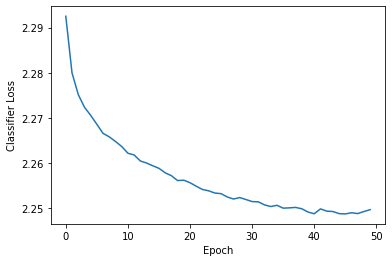

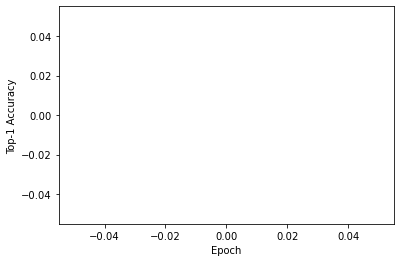

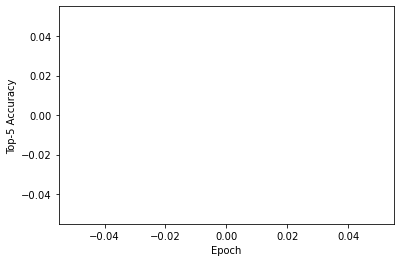

<Figure size 432x288 with 0 Axes>

In [10]:
'''Loading the Classifier Loss logs'''
with open(f"{out_dir}/classifier_loss_logs.pkl",'rb') as f:
    loss = pickle.load(f)
    f.close()
    
from matplotlib import pyplot as plt
plt.plot(loss[1])
# plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.figure()


''' plotting the Top-1 & Top-5 accuracy'''
plt.plot(acc1_hist)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.figure()
hist5 = [a.item() for a in acc5_hist]
plt.plot(hist5)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.figure()



In [11]:
from sklearn.mixture import GaussianMixture
import dataloader_cifar as dataloader

def get_train(model, dataloader, estimate_p_right=True, p_right_threshold=0.5, p_clean_threshold=0.5, CBS=True):
    model.eval()
    losses = []
    confidence = []
    label_preds = []
    crit = nn.CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda() 
            outputs = model(inputs)
            b_losses = crit(outputs, targets)
            probs, b_preds = torch.max(torch.softmax(outputs, dim=-1), dim=-1)
            confidence.append(probs)
            label_preds.append(b_preds)
            losses.append(b_losses)

    losses = torch.cat(losses, dim=0).cpu()
    confidence = torch.cat(confidence, dim=0).cpu()
    label_preds = torch.cat(label_preds, dim=0).cpu()
    losses = (losses-losses.min())/(losses.max()-losses.min())
    
    input_loss = losses.reshape(-1, 1)
    confidence = confidence.reshape(-1, 1)
    # fit a two-component GMM to the loss
    gmm1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm1.fit(input_loss)
    prob = gmm1.predict_proba(input_loss)
    p_clean = prob[:,gmm1.means_.argmin()]
    clean = (p_clean > p_clean_threshold)
    if estimate_p_right:
        gmm2 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
        gmm2.fit(confidence)
        print(gmm2.means_)
        prob = gmm2.predict_proba(confidence)
        p_right = prob[:, gmm2.means_.argmax()]
        relabel_indicator = p_right > p_right_threshold
        return loader.run('train', clean, p_clean, CBS=CBS,relabel_indicator=relabel_indicator, label_preds=label_preds)

    return loader.run('train', clean, p_clean, CBS=CBS)


In [12]:
print('remember to change rampup when finished searching for best lambda_u')
def linear_rampup(current, rampup_length=5):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch, lambda_u=75, unsupervised_term=True):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        if unsupervised_term:
            Lu = torch.mean((probs_u - targets_u) ** 2)
            return (Lx, Lu, lambda_u * linear_rampup(epoch))
        return (Lx,)


remember to change rampup when finished searching for best lambda_u


In [13]:
def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [14]:
def kronecker_product(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.shape
    t2_height, t2_width = t2.shape
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

In [15]:
import torch
from torch.nn import ReLU
from torch.nn.functional import normalize

Re = ReLU()
src = torch.ones(32,10)
lab_num = 32# len(L[0])
unlab_num = 64 #len(U)
one_vec1 = torch.ones(lab_num).unsqueeze(dim=0).cuda().detach()
one_vec = torch.ones(unlab_num).unsqueeze(dim=0).cuda().detach()

def graph_structured_regularization(model, L, U, lambda_uu, lambda_lu, tau): #U-unlabled class, L-labled, 
    A_lu = None
    A_uu = None
    with torch.no_grad():
        Z_l = model.encoder(L[0].cuda())
        Z_u = model.encoder(U.cuda())
        Z_l = normalize(Z_l,dim=1)
        Z_u = normalize(Z_u,dim=1)
        A_lu = Re(torch.matmul(Z_l, Z_u.t())-tau)
        A_uu = Re(torch.matmul(Z_u, Z_u.t())-tau)
    y_hat = L[1]
    p = model(U.cuda())
    p = torch.softmax(p, dim=-1)
    # P_mat = kronecker_product(one_vec, p).reshape(unlab_num, unlab_num, 10)
    P_mat = p.repeat(1, unlab_num).view(unlab_num, unlab_num, 10)
    P_mat1 = P_mat[:,:32,:] # kronecker_product(one_vec1, p).reshape(unlab_num, lab_num, 10)
    # Y_mat = kronecker_product(one_vec,y_hat).reshape(lab_num, unlab_num,10)
    Y_mat = y_hat.repeat(1, unlab_num).reshape(lab_num, unlab_num,10)
    P_mat1 = torch.transpose(P_mat1,0,1)
    norm_lu = torch.mean((P_mat1 - Y_mat) **2)
    norm_uu = torch.mean((P_mat - torch.transpose(P_mat,0,1) ** 2))
    return  (0.5 * lambda_uu*A_uu*norm_uu).sum() + (lambda_lu*A_lu*norm_lu).sum() 

In [16]:
import time
from tqdm.notebook  import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import functional as F



def train(labeled_trainloader, unlabeled_trainloader, model, criterion, T=0.5, alpha=0.75, train_iteration=1024, graph_reg=True, unsupervised_term=True, epochs=100, exp_name=None, lambda_u=75):
    acc1_hist = []
    acc5_hist = []
    losses_x_hist = []
    losses_u_hist = []
    losses_r_hist = []
    best_val = 0
    switch_encoder(model, state=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    optimizer.zero_grad()
    print(f"learnable paramters: {sum(torch.numel(p) for p in model.parameters() if p.requires_grad)}")
    for epoch in range(epochs):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        losses_x = AverageMeter()
        losses_u = AverageMeter()
        losses_r = AverageMeter()
        time_loss_r = AverageMeter()

        ws = AverageMeter()
        end = time.time()
        labeled_train_iter = iter(labeled_trainloader)
        unlabeled_train_iter = iter(unlabeled_trainloader)

        model.train()
        for batch_idx in tqdm(range(train_iteration)):
            try:
                inputs_x, targets_x = labeled_train_iter.next()
            except:
                labeled_train_iter = iter(labeled_trainloader)
                inputs_x, targets_x = labeled_train_iter.next()

            try:
                inputs_u, inputs_u2 = unlabeled_train_iter.next()
            except:
                unlabeled_train_iter = iter(unlabeled_trainloader)
                inputs_u, inputs_u2 = unlabeled_train_iter.next()

            # measure data loading time
            data_time.update(time.time() - end)

            batch_size = inputs_x.size(0)

            # Transform label to one-hot
            targets_x = torch.zeros(batch_size, 10).scatter_(1, targets_x.view(-1,1).long(), 1)

            inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
            inputs_u = inputs_u.cuda()
            inputs_u2 = inputs_u2.cuda()

            with torch.no_grad():
                # compute guessed labels of unlabel samples
                outputs_u = model(inputs_u)
                outputs_u2 = model(inputs_u2)
                p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
                pt = p ** (1 / T)
                targets_u = pt / pt.sum(dim=1, keepdim=True)
                targets_u = targets_u.detach()

            # mixup
            all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
            all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

            l = np.random.beta(alpha, alpha)

            l = max(l, 1-l)

            idx = torch.randperm(all_inputs.size(0))

            input_a, input_b = all_inputs, all_inputs[idx]
            target_a, target_b = all_targets, all_targets[idx]

            mixed_input = l * input_a + (1 - l) * input_b
            mixed_target = l * target_a + (1 - l) * target_b

            # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
            mixed_input = list(torch.split(mixed_input, batch_size))
            mixed_input = interleave(mixed_input, batch_size)

            logits = [model(mixed_input[0])]
            for input in mixed_input[1:]:
                logits.append(model(input))

            # put interleaved samples back
            logits = interleave(logits, batch_size)
            logits_x = logits[0]
            logits_u = torch.cat(logits[1:], dim=0)

            crit_res = criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration, unsupervised_term=unsupervised_term, lambda_u=lambda_u)
            Lx = crit_res[0]
            loss = Lx
            if unsupervised_term:
                Lu = crit_res[1] 
                w = crit_res[2]
                loss = loss + w * Lu

            if graph_reg:
                R = graph_structured_regularization(model, (inputs_x, targets_x), torch.cat([inputs_u, inputs_u2], dim=0), lambda_uu=0.01, lambda_lu=0.005, tau=0.5)
                loss = loss + R


            # record loss
            losses.update(loss.item(), inputs_x.size(0))
            losses_x.update(Lx.item(), inputs_x.size(0))
            if unsupervised_term:
                losses_u.update(Lu.item(), inputs_x.size(0))
                ws.update(w, inputs_x.size(0))
            if graph_reg:
                losses_r.update(R.item(), inputs_x.size(0))
            

            # compute gradient and do SGD step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            # plot progress
            if batch_idx % 100 == 0:
                print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | Loss_R: {loss_r:.4f} | W: {w:.4f}'.format(
                            batch=batch_idx + 1,
                            size=train_iteration,
                            data=data_time.avg,
                            bt=batch_time.avg,
                            loss=losses.avg,
                            loss_x=losses_x.avg,
                            loss_u=losses_u.avg,
                            loss_r=losses_r.avg,
                            w=ws.avg,
                            ))
                losses_x_hist.append(losses_x.avg)
                if unsupervised_term:
                    losses_u_hist.append(losses_u.avg)
                if graph_reg:
                    losses_r_hist.append(losses_r.avg)

            if batch_idx % 500 == 0:
                val,val5 = validate(model, val_dataloader)
                acc1_hist.append(val)
                acc5_hist.append(val5)
                
                if val > best_val:
                    best_val = val
                    best_model_wts = copy.deepcopy(model.state_dict())
            

    torch.save({'losses_x_hist': losses_x_hist, 'losses_u_hist': losses_u_hist, 'losses_r_hist': losses_r_hist, 'best_model_wts': best_model_wts, 'best_val': best_val, 'acc1_hist': acc1_hist, 'acc5_hist': acc5_hist}, f"runs/{exp_name}.bin")



In [45]:

from matplotlib import pyplot as plt
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_result(result):
    fig, axs = plt.subplots(2,2, figsize=(25, 10))
    def get_avg_x_axs(hist):
        values = map(lambda t:  (t[0]%11 != 0, (((1024 * (t[0]//11)) + (t[0]% 11) * 100)/ 1024), t[1]), enumerate(hist))
        filtered_values = filter(lambda t: t[0], values)
        return zip(*map(lambda t: (t[1], t[2]), filtered_values))


    acc1_x_axs = list(map(lambda x: ((1024 * (x//3)) + [0, 500, 1000][x%3]) / 1024, range(len(result['acc1_hist']))))
    x,y = get_avg_x_axs(result['losses_x_hist'])
    axs[0,0].plot(x, y)
    axs[0,0].set_title('Lx')
    axs[0,0].set_xlabel('epoch')
    x, y = get_avg_x_axs(result['losses_r_hist'])
    axs[0,1].plot(x, y)
    axs[0,1].set_title('R')
    axs[0,1].set_xlabel('epoch')
    x, y = get_avg_x_axs(result['losses_u_hist'])
    axs[1,0].plot(x, y)
    axs[1,0].set_title('Lu')
    axs[1,0].set_xlabel('epoch')
    axs[1,1].plot(acc1_x_axs, result['acc1_hist'])
    axs[1,1].set_title('Top-1 acc')
    axs[1,1].set_xlabel('epoch')


loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.25082084]
 [0.16920658]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

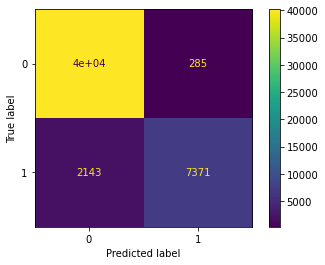

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

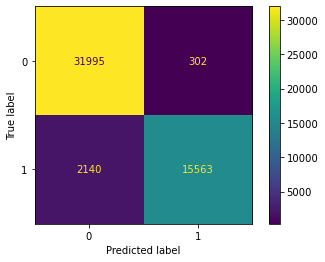

Numer of labeled samples:15865   AUC:0.663

labeled data has a size of 15865
using CBS
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34135
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
[[0.25152637]
 [0.16945637]]
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
Confusion matrix before re-labeling


<Figure size 432x288 with 0 Axes>

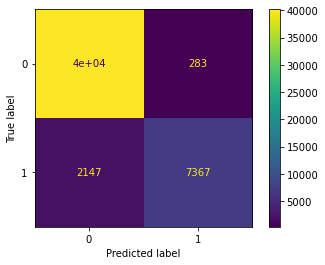

Confusion matrix after re-labeling


<Figure size 432x288 with 0 Axes>

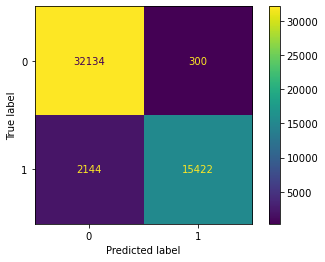

Numer of labeled samples:15722   AUC:0.665

labeled data has a size of 15722
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 34278


In [18]:
cbs_labeled_trainloader, cbs_unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=True)
labeled_trainloader, unlabeled_trainloader = get_train(model, loader.run('eval_train'), estimate_p_right=True, CBS=False)

In [19]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name='reproduce')

In [20]:
# CBS: True, GMM1: true, GMM2: true, unsupervised_term: false....
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=False, graph_reg=True, exp_name='no_unsupervised_term')

In [21]:
# train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=False, exp_name='no_graph_reg')
# plot_result(torch.load('runs/no_graph_reg.bin'))

In [22]:
# train(labeled_trainloader, unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name='no_cbs')
# plot_result(torch.load('runs/no_cbs.bin'))

In [23]:
# lambda_u_search
for current_lambda_u in [2 , 5 , 10 , 15, 20, 30, 150]:
    model.load_state_dict(torch.load(f"cifar10/clf_learning/final_model_wts.bin"))
    train(cbs_labeled_trainloader, cbs_unlabeled_trainloader, model, criterion=SemiLoss(), T=0.5, alpha=0.75, train_iteration=1024, unsupervised_term=True, graph_reg=True, exp_name=f'reproduce_lu_{current_lambda_u}', epochs=7, lambda_u=current_lambda_u)

learnable paramters: 23520842


(1/1024) Data: 0.314s | Batch: 0.706s | Loss: 2.0405 | Loss_x: 2.0104 | Loss_u: 0.0035 | Loss_R: 0.0301 | W: 0.0000



validation acc: top-1: 86.58, top-5: tensor([98.5000], device='cuda:0')
(101/1024) Data: 0.060s | Batch: 0.362s | Loss: 1.4712 | Loss_x: 1.3381 | Loss_u: 0.0120 | Loss_R: 0.1328 | W: 0.0195
(201/1024) Data: 0.033s | Batch: 0.336s | Loss: 1.3812 | Loss_x: 1.2502 | Loss_u: 0.0123 | Loss_R: 0.1306 | W: 0.0391
(301/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.3541 | Loss_x: 1.2197 | Loss_u: 0.0125 | Loss_R: 0.1337 | W: 0.0586
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.3337 | Loss_x: 1.1975 | Loss_u: 0.0125 | Loss_R: 0.1352 | W: 0.0781
(501/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.2992 | Loss_x: 1.1641 | Loss_u: 0.0124 | Loss_R: 0.1339 | W: 0.0977



validation acc: top-1: 80.01, top-5: tensor([98.3600], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.2656 | Loss_x: 1.1303 | Loss_u: 0.0123 | Loss_R: 0.1339 | W: 0.1172
(701/1024) Data: 0.021s | Batch: 0.325s | Loss: 1.2640 | Loss_x: 1.1281 | Loss_u: 0.0124 | Loss_R: 0.1341 | W: 0.1367
(801/1024) Data: 0.019s | Batch: 0.323s | Loss: 1.2660 | Loss_x: 1.1299 | Loss_u: 0.0127 | Loss_R: 0.1341 | W: 0.1562
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2561 | Loss_x: 1.1194 | Loss_u: 0.0127 | Loss_R: 0.1344 | W: 0.1758
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.2434 | Loss_x: 1.1067 | Loss_u: 0.0126 | Loss_R: 0.1342 | W: 0.1953



validation acc: top-1: 81.71, top-5: tensor([98.4800], device='cuda:0')



(1/1024) Data: 0.450s | Batch: 0.769s | Loss: 1.8702 | Loss_x: 1.8173 | Loss_u: 0.0101 | Loss_R: 0.0488 | W: 0.4000



validation acc: top-1: 86.42, top-5: tensor([98.8800], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.1848 | Loss_x: 1.0734 | Loss_u: 0.0125 | Loss_R: 0.1062 | W: 0.4195
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.1792 | Loss_x: 1.0616 | Loss_u: 0.0130 | Loss_R: 0.1119 | W: 0.4391
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1865 | Loss_x: 1.0671 | Loss_u: 0.0131 | Loss_R: 0.1133 | W: 0.4586
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1743 | Loss_x: 1.0536 | Loss_u: 0.0132 | Loss_R: 0.1144 | W: 0.4781
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1703 | Loss_x: 1.0484 | Loss_u: 0.0131 | Loss_R: 0.1153 | W: 0.4977



validation acc: top-1: 85.48, top-5: tensor([98.7800], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.1617 | Loss_x: 1.0398 | Loss_u: 0.0130 | Loss_R: 0.1152 | W: 0.5172
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1639 | Loss_x: 1.0414 | Loss_u: 0.0130 | Loss_R: 0.1156 | W: 0.5367
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1526 | Loss_x: 1.0305 | Loss_u: 0.0129 | Loss_R: 0.1149 | W: 0.5563
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1540 | Loss_x: 1.0319 | Loss_u: 0.0129 | Loss_R: 0.1147 | W: 0.5758
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1541 | Loss_x: 1.0320 | Loss_u: 0.0130 | Loss_R: 0.1144 | W: 0.5953



validation acc: top-1: 80.44, top-5: tensor([98.6500], device='cuda:0')



(1/1024) Data: 0.449s | Batch: 0.774s | Loss: 1.6925 | Loss_x: 1.6269 | Loss_u: 0.0114 | Loss_R: 0.0565 | W: 0.8000



validation acc: top-1: 86.36, top-5: tensor([98.3200], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.1395 | Loss_x: 1.0220 | Loss_u: 0.0129 | Loss_R: 0.1069 | W: 0.8195
(201/1024) Data: 0.034s | Batch: 0.339s | Loss: 1.1229 | Loss_x: 1.0032 | Loss_u: 0.0126 | Loss_R: 0.1091 | W: 0.8391
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1242 | Loss_x: 1.0024 | Loss_u: 0.0124 | Loss_R: 0.1111 | W: 0.8586
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1282 | Loss_x: 1.0066 | Loss_u: 0.0126 | Loss_R: 0.1105 | W: 0.8781
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1082 | Loss_x: 0.9876 | Loss_u: 0.0124 | Loss_R: 0.1096 | W: 0.8977



validation acc: top-1: 82.59, top-5: tensor([97.9600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.0872 | Loss_x: 0.9668 | Loss_u: 0.0122 | Loss_R: 0.1092 | W: 0.9172
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.0934 | Loss_x: 0.9730 | Loss_u: 0.0124 | Loss_R: 0.1088 | W: 0.9367
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0920 | Loss_x: 0.9726 | Loss_u: 0.0124 | Loss_R: 0.1076 | W: 0.9563
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0893 | Loss_x: 0.9704 | Loss_u: 0.0124 | Loss_R: 0.1068 | W: 0.9758
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.0864 | Loss_x: 0.9678 | Loss_u: 0.0124 | Loss_R: 0.1063 | W: 0.9953



validation acc: top-1: 82.7, top-5: tensor([97.9800], device='cuda:0')



(1/1024) Data: 0.483s | Batch: 0.807s | Loss: 1.3611 | Loss_x: 1.2867 | Loss_u: 0.0096 | Loss_R: 0.0629 | W: 1.2000



validation acc: top-1: 85.51, top-5: tensor([98.1300], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.1072 | Loss_x: 0.9887 | Loss_u: 0.0128 | Loss_R: 0.1029 | W: 1.2195
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.0941 | Loss_x: 0.9731 | Loss_u: 0.0127 | Loss_R: 0.1053 | W: 1.2391
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.0651 | Loss_x: 0.9461 | Loss_u: 0.0122 | Loss_R: 0.1038 | W: 1.2586
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0704 | Loss_x: 0.9521 | Loss_u: 0.0123 | Loss_R: 0.1026 | W: 1.2781
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.0721 | Loss_x: 0.9536 | Loss_u: 0.0125 | Loss_R: 0.1022 | W: 1.2977



validation acc: top-1: 83.85, top-5: tensor([97.7100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.0745 | Loss_x: 0.9573 | Loss_u: 0.0125 | Loss_R: 0.1007 | W: 1.3172
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.0663 | Loss_x: 0.9495 | Loss_u: 0.0124 | Loss_R: 0.1001 | W: 1.3367
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.0639 | Loss_x: 0.9467 | Loss_u: 0.0125 | Loss_R: 0.1003 | W: 1.3562
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0715 | Loss_x: 0.9545 | Loss_u: 0.0126 | Loss_R: 0.0996 | W: 1.3758
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.0635 | Loss_x: 0.9470 | Loss_u: 0.0125 | Loss_R: 0.0991 | W: 1.3953



validation acc: top-1: 83.85, top-5: tensor([96.6200], device='cuda:0')



(1/1024) Data: 0.472s | Batch: 0.796s | Loss: 0.8558 | Loss_x: 0.7540 | Loss_u: 0.0139 | Loss_R: 0.0796 | W: 1.6000



validation acc: top-1: 86.54, top-5: tensor([98.8500], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.365s | Loss: 1.0544 | Loss_x: 0.9370 | Loss_u: 0.0116 | Loss_R: 0.0986 | W: 1.6195
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.0683 | Loss_x: 0.9502 | Loss_u: 0.0118 | Loss_R: 0.0987 | W: 1.6391
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.0876 | Loss_x: 0.9692 | Loss_u: 0.0124 | Loss_R: 0.0977 | W: 1.6586
(401/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.0661 | Loss_x: 0.9477 | Loss_u: 0.0122 | Loss_R: 0.0980 | W: 1.6781
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0711 | Loss_x: 0.9517 | Loss_u: 0.0124 | Loss_R: 0.0984 | W: 1.6977



validation acc: top-1: 85.23, top-5: tensor([98.7800], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.329s | Loss: 1.0657 | Loss_x: 0.9469 | Loss_u: 0.0123 | Loss_R: 0.0976 | W: 1.7172
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.0621 | Loss_x: 0.9432 | Loss_u: 0.0123 | Loss_R: 0.0974 | W: 1.7367
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0641 | Loss_x: 0.9459 | Loss_u: 0.0124 | Loss_R: 0.0964 | W: 1.7562
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0636 | Loss_x: 0.9454 | Loss_u: 0.0124 | Loss_R: 0.0962 | W: 1.7758
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.0536 | Loss_x: 0.9361 | Loss_u: 0.0123 | Loss_R: 0.0955 | W: 1.7953



validation acc: top-1: 85.22, top-5: tensor([97.7100], device='cuda:0')



(1/1024) Data: 0.482s | Batch: 0.802s | Loss: 0.8882 | Loss_x: 0.7891 | Loss_u: 0.0108 | Loss_R: 0.0775 | W: 2.0000



validation acc: top-1: 85.74, top-5: tensor([97.8700], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.0683 | Loss_x: 0.9470 | Loss_u: 0.0124 | Loss_R: 0.0966 | W: 2.0000
(201/1024) Data: 0.034s | Batch: 0.339s | Loss: 1.0690 | Loss_x: 0.9395 | Loss_u: 0.0129 | Loss_R: 0.1036 | W: 2.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.0479 | Loss_x: 0.9238 | Loss_u: 0.0126 | Loss_R: 0.0990 | W: 2.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0423 | Loss_x: 0.9191 | Loss_u: 0.0126 | Loss_R: 0.0980 | W: 2.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0271 | Loss_x: 0.9056 | Loss_u: 0.0122 | Loss_R: 0.0970 | W: 2.0000



validation acc: top-1: 85.78, top-5: tensor([98.8600], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.0283 | Loss_x: 0.9074 | Loss_u: 0.0122 | Loss_R: 0.0964 | W: 2.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.0280 | Loss_x: 0.9079 | Loss_u: 0.0123 | Loss_R: 0.0956 | W: 2.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0245 | Loss_x: 0.9056 | Loss_u: 0.0123 | Loss_R: 0.0942 | W: 2.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0243 | Loss_x: 0.9067 | Loss_u: 0.0123 | Loss_R: 0.0930 | W: 2.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.0274 | Loss_x: 0.9108 | Loss_u: 0.0124 | Loss_R: 0.0920 | W: 2.0000



validation acc: top-1: 83.74, top-5: tensor([98.4800], device='cuda:0')



(1/1024) Data: 0.467s | Batch: 0.792s | Loss: 1.5444 | Loss_x: 1.4269 | Loss_u: 0.0138 | Loss_R: 0.0900 | W: 2.0000



validation acc: top-1: 86.15, top-5: tensor([99.0800], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.0822 | Loss_x: 0.9600 | Loss_u: 0.0130 | Loss_R: 0.0962 | W: 2.0000
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.0668 | Loss_x: 0.9434 | Loss_u: 0.0128 | Loss_R: 0.0979 | W: 2.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.0674 | Loss_x: 0.9457 | Loss_u: 0.0128 | Loss_R: 0.0961 | W: 2.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0469 | Loss_x: 0.9275 | Loss_u: 0.0124 | Loss_R: 0.0945 | W: 2.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0405 | Loss_x: 0.9228 | Loss_u: 0.0124 | Loss_R: 0.0929 | W: 2.0000



validation acc: top-1: 86.6, top-5: tensor([98.5900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.0520 | Loss_x: 0.9338 | Loss_u: 0.0127 | Loss_R: 0.0929 | W: 2.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.0599 | Loss_x: 0.9425 | Loss_u: 0.0128 | Loss_R: 0.0918 | W: 2.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0506 | Loss_x: 0.9331 | Loss_u: 0.0127 | Loss_R: 0.0920 | W: 2.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.0437 | Loss_x: 0.9275 | Loss_u: 0.0125 | Loss_R: 0.0911 | W: 2.0000
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.0403 | Loss_x: 0.9244 | Loss_u: 0.0125 | Loss_R: 0.0908 | W: 2.0000



validation acc: top-1: 84.67, top-5: tensor([98.6700], device='cuda:0')

learnable paramters: 23520842


(1/1024) Data: 0.300s | Batch: 0.641s | Loss: 1.8669 | Loss_x: 1.8394 | Loss_u: 0.0013 | Loss_R: 0.0275 | W: 0.0000



validation acc: top-1: 86.72, top-5: tensor([98.7300], device='cuda:0')
(101/1024) Data: 0.061s | Batch: 0.365s | Loss: 1.5448 | Loss_x: 1.3691 | Loss_u: 0.0117 | Loss_R: 0.1752 | W: 0.0488
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.4255 | Loss_x: 1.2714 | Loss_u: 0.0119 | Loss_R: 0.1529 | W: 0.0977
(301/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.3713 | Loss_x: 1.2256 | Loss_u: 0.0119 | Loss_R: 0.1440 | W: 0.1465
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.3186 | Loss_x: 1.1781 | Loss_u: 0.0119 | Loss_R: 0.1382 | W: 0.1953
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2983 | Loss_x: 1.1595 | Loss_u: 0.0120 | Loss_R: 0.1359 | W: 0.2441



validation acc: top-1: 81.95, top-5: tensor([98.7700], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.2714 | Loss_x: 1.1337 | Loss_u: 0.0120 | Loss_R: 0.1342 | W: 0.2930
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2662 | Loss_x: 1.1282 | Loss_u: 0.0122 | Loss_R: 0.1338 | W: 0.3418
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2528 | Loss_x: 1.1155 | Loss_u: 0.0121 | Loss_R: 0.1325 | W: 0.3906
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2431 | Loss_x: 1.1062 | Loss_u: 0.0122 | Loss_R: 0.1314 | W: 0.4395
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2379 | Loss_x: 1.1018 | Loss_u: 0.0122 | Loss_R: 0.1301 | W: 0.4883



validation acc: top-1: 77.9, top-5: tensor([97.6800], device='cuda:0')



(1/1024) Data: 0.476s | Batch: 0.802s | Loss: 1.5248 | Loss_x: 1.4658 | Loss_u: 0.0083 | Loss_R: 0.0507 | W: 1.0000



validation acc: top-1: 82.85, top-5: tensor([98.6400], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.1621 | Loss_x: 1.0447 | Loss_u: 0.0126 | Loss_R: 0.1042 | W: 1.0488
(201/1024) Data: 0.035s | Batch: 0.338s | Loss: 1.1577 | Loss_x: 1.0325 | Loss_u: 0.0123 | Loss_R: 0.1117 | W: 1.0977
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1444 | Loss_x: 1.0170 | Loss_u: 0.0123 | Loss_R: 0.1133 | W: 1.1465
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1458 | Loss_x: 1.0170 | Loss_u: 0.0123 | Loss_R: 0.1141 | W: 1.1953
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1506 | Loss_x: 1.0202 | Loss_u: 0.0124 | Loss_R: 0.1151 | W: 1.2441



validation acc: top-1: 85.2, top-5: tensor([98.4300], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.1358 | Loss_x: 1.0060 | Loss_u: 0.0123 | Loss_R: 0.1140 | W: 1.2930
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1495 | Loss_x: 1.0191 | Loss_u: 0.0125 | Loss_R: 0.1135 | W: 1.3418
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1403 | Loss_x: 1.0099 | Loss_u: 0.0125 | Loss_R: 0.1129 | W: 1.3906
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1394 | Loss_x: 1.0089 | Loss_u: 0.0126 | Loss_R: 0.1124 | W: 1.4395
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1346 | Loss_x: 1.0042 | Loss_u: 0.0125 | Loss_R: 0.1118 | W: 1.4883



validation acc: top-1: 80.45, top-5: tensor([97.7300], device='cuda:0')



(1/1024) Data: 0.471s | Batch: 0.790s | Loss: 1.7439 | Loss_x: 1.6561 | Loss_u: 0.0119 | Loss_R: 0.0640 | W: 2.0000



validation acc: top-1: 86.46, top-5: tensor([98.6900], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.364s | Loss: 1.1009 | Loss_x: 0.9704 | Loss_u: 0.0123 | Loss_R: 0.1052 | W: 2.0488
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.1351 | Loss_x: 1.0007 | Loss_u: 0.0126 | Loss_R: 0.1080 | W: 2.0977
(301/1024) Data: 0.025s | Batch: 0.327s | Loss: 1.1442 | Loss_x: 1.0067 | Loss_u: 0.0127 | Loss_R: 0.1101 | W: 2.1465
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1229 | Loss_x: 0.9877 | Loss_u: 0.0124 | Loss_R: 0.1080 | W: 2.1953
(501/1024) Data: 0.018s | Batch: 0.320s | Loss: 1.1265 | Loss_x: 0.9918 | Loss_u: 0.0125 | Loss_R: 0.1068 | W: 2.2441



validation acc: top-1: 83.75, top-5: tensor([97.5600], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.1209 | Loss_x: 0.9859 | Loss_u: 0.0125 | Loss_R: 0.1065 | W: 2.2930
(701/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.1180 | Loss_x: 0.9838 | Loss_u: 0.0125 | Loss_R: 0.1050 | W: 2.3418
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.1227 | Loss_x: 0.9879 | Loss_u: 0.0126 | Loss_R: 0.1047 | W: 2.3906
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1211 | Loss_x: 0.9867 | Loss_u: 0.0125 | Loss_R: 0.1038 | W: 2.4395
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1168 | Loss_x: 0.9826 | Loss_u: 0.0125 | Loss_R: 0.1032 | W: 2.4883



validation acc: top-1: 86.29, top-5: tensor([98.4100], device='cuda:0')



(1/1024) Data: 0.473s | Batch: 0.797s | Loss: 0.9530 | Loss_x: 0.8386 | Loss_u: 0.0133 | Loss_R: 0.0744 | W: 3.0000



validation acc: top-1: 87.19, top-5: tensor([98.9700], device='cuda:0')
(101/1024) Data: 0.061s | Batch: 0.365s | Loss: 1.2177 | Loss_x: 1.0694 | Loss_u: 0.0138 | Loss_R: 0.1062 | W: 3.0488
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.1714 | Loss_x: 1.0236 | Loss_u: 0.0133 | Loss_R: 0.1066 | W: 3.0977
(301/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.1492 | Loss_x: 1.0026 | Loss_u: 0.0130 | Loss_R: 0.1059 | W: 3.1465
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1444 | Loss_x: 0.9983 | Loss_u: 0.0130 | Loss_R: 0.1046 | W: 3.1953
(501/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1318 | Loss_x: 0.9867 | Loss_u: 0.0129 | Loss_R: 0.1034 | W: 3.2441



validation acc: top-1: 82.52, top-5: tensor([97.1700], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.1111 | Loss_x: 0.9672 | Loss_u: 0.0126 | Loss_R: 0.1024 | W: 3.2930
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1076 | Loss_x: 0.9640 | Loss_u: 0.0126 | Loss_R: 0.1015 | W: 3.3418
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.0925 | Loss_x: 0.9492 | Loss_u: 0.0125 | Loss_R: 0.1010 | W: 3.3906
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.0945 | Loss_x: 0.9510 | Loss_u: 0.0125 | Loss_R: 0.1005 | W: 3.4395
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.0929 | Loss_x: 0.9499 | Loss_u: 0.0125 | Loss_R: 0.0995 | W: 3.4883



validation acc: top-1: 81.69, top-5: tensor([96.8600], device='cuda:0')



(1/1024) Data: 0.478s | Batch: 0.802s | Loss: 1.2817 | Loss_x: 1.1739 | Loss_u: 0.0091 | Loss_R: 0.0713 | W: 4.0000



validation acc: top-1: 85.83, top-5: tensor([98.9400], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.1292 | Loss_x: 0.9754 | Loss_u: 0.0124 | Loss_R: 0.1035 | W: 4.0488
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.1041 | Loss_x: 0.9528 | Loss_u: 0.0120 | Loss_R: 0.1022 | W: 4.0977
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1073 | Loss_x: 0.9574 | Loss_u: 0.0122 | Loss_R: 0.0993 | W: 4.1465
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0873 | Loss_x: 0.9379 | Loss_u: 0.0120 | Loss_R: 0.0992 | W: 4.1953
(501/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.0832 | Loss_x: 0.9344 | Loss_u: 0.0119 | Loss_R: 0.0983 | W: 4.2441



validation acc: top-1: 84.76, top-5: tensor([98.7400], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.0752 | Loss_x: 0.9267 | Loss_u: 0.0119 | Loss_R: 0.0975 | W: 4.2930
(701/1024) Data: 0.021s | Batch: 0.325s | Loss: 1.0798 | Loss_x: 0.9320 | Loss_u: 0.0119 | Loss_R: 0.0962 | W: 4.3418
(801/1024) Data: 0.019s | Batch: 0.323s | Loss: 1.0811 | Loss_x: 0.9337 | Loss_u: 0.0120 | Loss_R: 0.0947 | W: 4.3906
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.0868 | Loss_x: 0.9383 | Loss_u: 0.0122 | Loss_R: 0.0945 | W: 4.4395
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.0903 | Loss_x: 0.9413 | Loss_u: 0.0122 | Loss_R: 0.0942 | W: 4.4883



validation acc: top-1: 85.03, top-5: tensor([98.2300], device='cuda:0')



(1/1024) Data: 0.481s | Batch: 0.804s | Loss: 1.1938 | Loss_x: 1.0636 | Loss_u: 0.0094 | Loss_R: 0.0833 | W: 5.0000



validation acc: top-1: 87.56, top-5: tensor([99.0500], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.366s | Loss: 1.0465 | Loss_x: 0.8896 | Loss_u: 0.0119 | Loss_R: 0.0972 | W: 5.0000
(201/1024) Data: 0.035s | Batch: 0.338s | Loss: 1.0550 | Loss_x: 0.8976 | Loss_u: 0.0120 | Loss_R: 0.0973 | W: 5.0000
(301/1024) Data: 0.026s | Batch: 0.329s | Loss: 1.0815 | Loss_x: 0.9247 | Loss_u: 0.0123 | Loss_R: 0.0954 | W: 5.0000
(401/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.0821 | Loss_x: 0.9261 | Loss_u: 0.0121 | Loss_R: 0.0954 | W: 5.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0761 | Loss_x: 0.9220 | Loss_u: 0.0120 | Loss_R: 0.0940 | W: 5.0000



validation acc: top-1: 86.14, top-5: tensor([98.8000], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.0644 | Loss_x: 0.9118 | Loss_u: 0.0120 | Loss_R: 0.0928 | W: 5.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.0583 | Loss_x: 0.9073 | Loss_u: 0.0119 | Loss_R: 0.0916 | W: 5.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0523 | Loss_x: 0.9020 | Loss_u: 0.0118 | Loss_R: 0.0910 | W: 5.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.0601 | Loss_x: 0.9094 | Loss_u: 0.0120 | Loss_R: 0.0907 | W: 5.0000
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.0556 | Loss_x: 0.9054 | Loss_u: 0.0120 | Loss_R: 0.0901 | W: 5.0000



validation acc: top-1: 84.28, top-5: tensor([98.1400], device='cuda:0')



(1/1024) Data: 0.471s | Batch: 0.795s | Loss: 1.2373 | Loss_x: 1.1025 | Loss_u: 0.0091 | Loss_R: 0.0892 | W: 5.0000



validation acc: top-1: 85.36, top-5: tensor([98.8500], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.0741 | Loss_x: 0.9144 | Loss_u: 0.0121 | Loss_R: 0.0991 | W: 5.0000
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.0986 | Loss_x: 0.9380 | Loss_u: 0.0128 | Loss_R: 0.0968 | W: 5.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.0677 | Loss_x: 0.9107 | Loss_u: 0.0124 | Loss_R: 0.0952 | W: 5.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.0728 | Loss_x: 0.9171 | Loss_u: 0.0125 | Loss_R: 0.0933 | W: 5.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.0897 | Loss_x: 0.9338 | Loss_u: 0.0127 | Loss_R: 0.0925 | W: 5.0000



validation acc: top-1: 82.67, top-5: tensor([98.0200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.0892 | Loss_x: 0.9351 | Loss_u: 0.0126 | Loss_R: 0.0909 | W: 5.0000
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.0874 | Loss_x: 0.9349 | Loss_u: 0.0126 | Loss_R: 0.0895 | W: 5.0000
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.0788 | Loss_x: 0.9274 | Loss_u: 0.0124 | Loss_R: 0.0892 | W: 5.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.0733 | Loss_x: 0.9232 | Loss_u: 0.0124 | Loss_R: 0.0883 | W: 5.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.0750 | Loss_x: 0.9249 | Loss_u: 0.0125 | Loss_R: 0.0879 | W: 5.0000



validation acc: top-1: 82.68, top-5: tensor([97.8900], device='cuda:0')

learnable paramters: 23520842


(1/1024) Data: 0.311s | Batch: 0.645s | Loss: 1.9701 | Loss_x: 1.9410 | Loss_u: 0.0038 | Loss_R: 0.0291 | W: 0.0000



validation acc: top-1: 87.05, top-5: tensor([98.6700], device='cuda:0')
(101/1024) Data: 0.061s | Batch: 0.363s | Loss: 1.4709 | Loss_x: 1.3391 | Loss_u: 0.0127 | Loss_R: 0.1305 | W: 0.0977
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.3454 | Loss_x: 1.2117 | Loss_u: 0.0123 | Loss_R: 0.1313 | W: 0.1953
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.3357 | Loss_x: 1.2040 | Loss_u: 0.0128 | Loss_R: 0.1278 | W: 0.2930
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.3039 | Loss_x: 1.1723 | Loss_u: 0.0127 | Loss_R: 0.1266 | W: 0.3906
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3016 | Loss_x: 1.1676 | Loss_u: 0.0128 | Loss_R: 0.1277 | W: 0.4883



validation acc: top-1: 85.27, top-5: tensor([98.7300], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.327s | Loss: 1.2788 | Loss_x: 1.1439 | Loss_u: 0.0127 | Loss_R: 0.1275 | W: 0.5859
(701/1024) Data: 0.022s | Batch: 0.324s | Loss: 1.2634 | Loss_x: 1.1274 | Loss_u: 0.0126 | Loss_R: 0.1275 | W: 0.6836
(801/1024) Data: 0.020s | Batch: 0.322s | Loss: 1.2560 | Loss_x: 1.1194 | Loss_u: 0.0126 | Loss_R: 0.1267 | W: 0.7812
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2488 | Loss_x: 1.1115 | Loss_u: 0.0126 | Loss_R: 0.1262 | W: 0.8789
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.2367 | Loss_x: 1.0987 | Loss_u: 0.0126 | Loss_R: 0.1258 | W: 0.9766



validation acc: top-1: 81.36, top-5: tensor([98.0600], device='cuda:0')



(1/1024) Data: 0.464s | Batch: 0.788s | Loss: 1.9388 | Loss_x: 1.8665 | Loss_u: 0.0115 | Loss_R: 0.0493 | W: 2.0000



validation acc: top-1: 85.7, top-5: tensor([98.8700], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.1405 | Loss_x: 1.0177 | Loss_u: 0.0119 | Loss_R: 0.0980 | W: 2.0977
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.1386 | Loss_x: 1.0086 | Loss_u: 0.0120 | Loss_R: 0.1037 | W: 2.1953
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1548 | Loss_x: 1.0200 | Loss_u: 0.0121 | Loss_R: 0.1069 | W: 2.2930
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1289 | Loss_x: 0.9928 | Loss_u: 0.0120 | Loss_R: 0.1074 | W: 2.3906
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1295 | Loss_x: 0.9902 | Loss_u: 0.0121 | Loss_R: 0.1091 | W: 2.4883



validation acc: top-1: 84.53, top-5: tensor([98.5300], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.1438 | Loss_x: 1.0021 | Loss_u: 0.0123 | Loss_R: 0.1097 | W: 2.5859
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1479 | Loss_x: 1.0050 | Loss_u: 0.0124 | Loss_R: 0.1095 | W: 2.6836
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1511 | Loss_x: 1.0078 | Loss_u: 0.0124 | Loss_R: 0.1087 | W: 2.7812
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1532 | Loss_x: 1.0084 | Loss_u: 0.0125 | Loss_R: 0.1088 | W: 2.8789
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1481 | Loss_x: 1.0024 | Loss_u: 0.0124 | Loss_R: 0.1087 | W: 2.9766



validation acc: top-1: 84.2, top-5: tensor([98.7200], device='cuda:0')



(1/1024) Data: 0.478s | Batch: 0.796s | Loss: 1.1466 | Loss_x: 1.0556 | Loss_u: 0.0089 | Loss_R: 0.0555 | W: 4.0000



validation acc: top-1: 85.35, top-5: tensor([98.6200], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.1439 | Loss_x: 0.9947 | Loss_u: 0.0120 | Loss_R: 0.0999 | W: 4.0977
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.1590 | Loss_x: 1.0041 | Loss_u: 0.0124 | Loss_R: 0.1029 | W: 4.1953
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1499 | Loss_x: 0.9942 | Loss_u: 0.0123 | Loss_R: 0.1030 | W: 4.2930
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1563 | Loss_x: 0.9980 | Loss_u: 0.0123 | Loss_R: 0.1043 | W: 4.3906
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1473 | Loss_x: 0.9885 | Loss_u: 0.0123 | Loss_R: 0.1037 | W: 4.4883



validation acc: top-1: 85.12, top-5: tensor([98.0500], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.1339 | Loss_x: 0.9740 | Loss_u: 0.0122 | Loss_R: 0.1039 | W: 4.5859
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1229 | Loss_x: 0.9633 | Loss_u: 0.0120 | Loss_R: 0.1033 | W: 4.6836
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1244 | Loss_x: 0.9637 | Loss_u: 0.0121 | Loss_R: 0.1030 | W: 4.7812
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1205 | Loss_x: 0.9596 | Loss_u: 0.0121 | Loss_R: 0.1020 | W: 4.8789
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1215 | Loss_x: 0.9596 | Loss_u: 0.0121 | Loss_R: 0.1019 | W: 4.9766



validation acc: top-1: 85.15, top-5: tensor([98.8600], device='cuda:0')



(1/1024) Data: 0.480s | Batch: 0.801s | Loss: 1.0816 | Loss_x: 0.9439 | Loss_u: 0.0117 | Loss_R: 0.0673 | W: 6.0000



validation acc: top-1: 86.83, top-5: tensor([98.6400], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.365s | Loss: 1.1591 | Loss_x: 0.9837 | Loss_u: 0.0123 | Loss_R: 0.1002 | W: 6.0977
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.1721 | Loss_x: 0.9904 | Loss_u: 0.0127 | Loss_R: 0.1029 | W: 6.1953
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1568 | Loss_x: 0.9743 | Loss_u: 0.0125 | Loss_R: 0.1041 | W: 6.2930
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1502 | Loss_x: 0.9683 | Loss_u: 0.0123 | Loss_R: 0.1033 | W: 6.3906
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1435 | Loss_x: 0.9622 | Loss_u: 0.0123 | Loss_R: 0.1019 | W: 6.4883



validation acc: top-1: 86.16, top-5: tensor([98.6900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1507 | Loss_x: 0.9681 | Loss_u: 0.0124 | Loss_R: 0.1010 | W: 6.5859
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1559 | Loss_x: 0.9729 | Loss_u: 0.0124 | Loss_R: 0.1000 | W: 6.6836
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1542 | Loss_x: 0.9707 | Loss_u: 0.0124 | Loss_R: 0.0992 | W: 6.7812
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1425 | Loss_x: 0.9591 | Loss_u: 0.0123 | Loss_R: 0.0988 | W: 6.8789
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1440 | Loss_x: 0.9591 | Loss_u: 0.0124 | Loss_R: 0.0986 | W: 6.9766



validation acc: top-1: 86.72, top-5: tensor([99.0800], device='cuda:0')



(1/1024) Data: 0.449s | Batch: 0.767s | Loss: 1.3561 | Loss_x: 1.1858 | Loss_u: 0.0115 | Loss_R: 0.0784 | W: 8.0000



validation acc: top-1: 86.61, top-5: tensor([98.6200], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.365s | Loss: 1.0390 | Loss_x: 0.8540 | Loss_u: 0.0107 | Loss_R: 0.0986 | W: 8.0977
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.1135 | Loss_x: 0.9155 | Loss_u: 0.0120 | Loss_R: 0.0998 | W: 8.1953
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1156 | Loss_x: 0.9175 | Loss_u: 0.0118 | Loss_R: 0.0998 | W: 8.2930
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1181 | Loss_x: 0.9190 | Loss_u: 0.0119 | Loss_R: 0.0992 | W: 8.3906
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1109 | Loss_x: 0.9122 | Loss_u: 0.0118 | Loss_R: 0.0981 | W: 8.4883



validation acc: top-1: 85.94, top-5: tensor([97.8100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1142 | Loss_x: 0.9153 | Loss_u: 0.0119 | Loss_R: 0.0971 | W: 8.5859
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1131 | Loss_x: 0.9137 | Loss_u: 0.0119 | Loss_R: 0.0963 | W: 8.6836
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1155 | Loss_x: 0.9160 | Loss_u: 0.0119 | Loss_R: 0.0954 | W: 8.7812
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1234 | Loss_x: 0.9230 | Loss_u: 0.0119 | Loss_R: 0.0943 | W: 8.8789
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1257 | Loss_x: 0.9239 | Loss_u: 0.0120 | Loss_R: 0.0941 | W: 8.9766



validation acc: top-1: 85.67, top-5: tensor([98.6700], device='cuda:0')



(1/1024) Data: 0.460s | Batch: 0.787s | Loss: 0.8526 | Loss_x: 0.6553 | Loss_u: 0.0122 | Loss_R: 0.0754 | W: 10.0000



validation acc: top-1: 86.54, top-5: tensor([99.0100], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.365s | Loss: 1.1421 | Loss_x: 0.9230 | Loss_u: 0.0121 | Loss_R: 0.0978 | W: 10.0000
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 1.1204 | Loss_x: 0.9065 | Loss_u: 0.0116 | Loss_R: 0.0980 | W: 10.0000
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1152 | Loss_x: 0.9050 | Loss_u: 0.0114 | Loss_R: 0.0962 | W: 10.0000
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1359 | Loss_x: 0.9212 | Loss_u: 0.0117 | Loss_R: 0.0975 | W: 10.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1424 | Loss_x: 0.9257 | Loss_u: 0.0119 | Loss_R: 0.0978 | W: 10.0000



validation acc: top-1: 87.02, top-5: tensor([98.6000], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.1446 | Loss_x: 0.9287 | Loss_u: 0.0120 | Loss_R: 0.0959 | W: 10.0000
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1453 | Loss_x: 0.9291 | Loss_u: 0.0120 | Loss_R: 0.0958 | W: 10.0000
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1438 | Loss_x: 0.9284 | Loss_u: 0.0121 | Loss_R: 0.0947 | W: 10.0000
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1354 | Loss_x: 0.9211 | Loss_u: 0.0120 | Loss_R: 0.0944 | W: 10.0000
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1392 | Loss_x: 0.9249 | Loss_u: 0.0121 | Loss_R: 0.0934 | W: 10.0000



validation acc: top-1: 83.36, top-5: tensor([98.6700], device='cuda:0')



(1/1024) Data: 0.478s | Batch: 0.803s | Loss: 1.0004 | Loss_x: 0.8069 | Loss_u: 0.0102 | Loss_R: 0.0912 | W: 10.0000



validation acc: top-1: 85.91, top-5: tensor([98.9800], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.1240 | Loss_x: 0.9135 | Loss_u: 0.0118 | Loss_R: 0.0923 | W: 10.0000
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 1.1436 | Loss_x: 0.9301 | Loss_u: 0.0122 | Loss_R: 0.0917 | W: 10.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1257 | Loss_x: 0.9160 | Loss_u: 0.0119 | Loss_R: 0.0903 | W: 10.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1166 | Loss_x: 0.9062 | Loss_u: 0.0119 | Loss_R: 0.0917 | W: 10.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1245 | Loss_x: 0.9152 | Loss_u: 0.0119 | Loss_R: 0.0901 | W: 10.0000



validation acc: top-1: 86.07, top-5: tensor([98.0300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1233 | Loss_x: 0.9132 | Loss_u: 0.0120 | Loss_R: 0.0901 | W: 10.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.1172 | Loss_x: 0.9084 | Loss_u: 0.0119 | Loss_R: 0.0896 | W: 10.0000
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1177 | Loss_x: 0.9097 | Loss_u: 0.0119 | Loss_R: 0.0886 | W: 10.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1216 | Loss_x: 0.9133 | Loss_u: 0.0120 | Loss_R: 0.0880 | W: 10.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1223 | Loss_x: 0.9144 | Loss_u: 0.0121 | Loss_R: 0.0872 | W: 10.0000



validation acc: top-1: 85.85, top-5: tensor([98.8600], device='cuda:0')

learnable paramters: 23520842


(1/1024) Data: 0.316s | Batch: 0.648s | Loss: 2.2080 | Loss_x: 2.1799 | Loss_u: 0.0059 | Loss_R: 0.0281 | W: 0.0000



validation acc: top-1: 86.53, top-5: tensor([98.3700], device='cuda:0')
(101/1024) Data: 0.061s | Batch: 0.364s | Loss: 1.3992 | Loss_x: 1.2785 | Loss_u: 0.0124 | Loss_R: 0.1189 | W: 0.1465
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.3381 | Loss_x: 1.2177 | Loss_u: 0.0122 | Loss_R: 0.1168 | W: 0.2930
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.3116 | Loss_x: 1.1873 | Loss_u: 0.0124 | Loss_R: 0.1187 | W: 0.4395
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2858 | Loss_x: 1.1597 | Loss_u: 0.0123 | Loss_R: 0.1189 | W: 0.5859
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2706 | Loss_x: 1.1435 | Loss_u: 0.0125 | Loss_R: 0.1177 | W: 0.7324



validation acc: top-1: 80.8, top-5: tensor([98.0300], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.2420 | Loss_x: 1.1148 | Loss_u: 0.0123 | Loss_R: 0.1165 | W: 0.8789
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2354 | Loss_x: 1.1051 | Loss_u: 0.0124 | Loss_R: 0.1176 | W: 1.0254
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2316 | Loss_x: 1.0989 | Loss_u: 0.0125 | Loss_R: 0.1180 | W: 1.1719
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2376 | Loss_x: 1.1022 | Loss_u: 0.0126 | Loss_R: 0.1185 | W: 1.3184
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2255 | Loss_x: 1.0894 | Loss_u: 0.0126 | Loss_R: 0.1175 | W: 1.4648



validation acc: top-1: 84.73, top-5: tensor([98.4200], device='cuda:0')



(1/1024) Data: 0.473s | Batch: 0.795s | Loss: 1.2964 | Loss_x: 1.2255 | Loss_u: 0.0081 | Loss_R: 0.0464 | W: 3.0000



validation acc: top-1: 84.39, top-5: tensor([98.1700], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.3213 | Loss_x: 1.1734 | Loss_u: 0.0135 | Loss_R: 0.1056 | W: 3.1465
(201/1024) Data: 0.035s | Batch: 0.338s | Loss: 1.2621 | Loss_x: 1.1119 | Loss_u: 0.0130 | Loss_R: 0.1075 | W: 3.2930
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2232 | Loss_x: 1.0723 | Loss_u: 0.0128 | Loss_R: 0.1071 | W: 3.4395
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2326 | Loss_x: 1.0781 | Loss_u: 0.0130 | Loss_R: 0.1080 | W: 3.5859
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2137 | Loss_x: 1.0579 | Loss_u: 0.0127 | Loss_R: 0.1083 | W: 3.7324



validation acc: top-1: 85.99, top-5: tensor([98.7800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1769 | Loss_x: 1.0228 | Loss_u: 0.0123 | Loss_R: 0.1069 | W: 3.8789
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1696 | Loss_x: 1.0141 | Loss_u: 0.0123 | Loss_R: 0.1066 | W: 4.0254
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1666 | Loss_x: 1.0098 | Loss_u: 0.0122 | Loss_R: 0.1061 | W: 4.1719
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1638 | Loss_x: 1.0055 | Loss_u: 0.0122 | Loss_R: 0.1059 | W: 4.3184
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1747 | Loss_x: 1.0137 | Loss_u: 0.0124 | Loss_R: 0.1058 | W: 4.4648



validation acc: top-1: 85.77, top-5: tensor([98.2800], device='cuda:0')



(1/1024) Data: 0.466s | Batch: 0.790s | Loss: 1.0444 | Loss_x: 0.9045 | Loss_u: 0.0129 | Loss_R: 0.0622 | W: 6.0000



validation acc: top-1: 86.08, top-5: tensor([98.5900], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.2073 | Loss_x: 1.0245 | Loss_u: 0.0132 | Loss_R: 0.1016 | W: 6.1465
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.2236 | Loss_x: 1.0356 | Loss_u: 0.0134 | Loss_R: 0.1036 | W: 6.2930
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2398 | Loss_x: 1.0495 | Loss_u: 0.0135 | Loss_R: 0.1035 | W: 6.4395
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2124 | Loss_x: 1.0244 | Loss_u: 0.0131 | Loss_R: 0.1020 | W: 6.5859
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1802 | Loss_x: 0.9950 | Loss_u: 0.0126 | Loss_R: 0.1010 | W: 6.7324



validation acc: top-1: 84.96, top-5: tensor([98.2500], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.1882 | Loss_x: 1.0011 | Loss_u: 0.0126 | Loss_R: 0.1005 | W: 6.8789
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.1786 | Loss_x: 0.9907 | Loss_u: 0.0125 | Loss_R: 0.1005 | W: 7.0254
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1690 | Loss_x: 0.9810 | Loss_u: 0.0123 | Loss_R: 0.1000 | W: 7.1719
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1706 | Loss_x: 0.9813 | Loss_u: 0.0123 | Loss_R: 0.0996 | W: 7.3184
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1592 | Loss_x: 0.9700 | Loss_u: 0.0121 | Loss_R: 0.0992 | W: 7.4648



validation acc: top-1: 83.22, top-5: tensor([98.0200], device='cuda:0')



(1/1024) Data: 0.471s | Batch: 0.794s | Loss: 1.0206 | Loss_x: 0.8236 | Loss_u: 0.0140 | Loss_R: 0.0706 | W: 9.0000



validation acc: top-1: 85.34, top-5: tensor([98.4700], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.366s | Loss: 1.1217 | Loss_x: 0.9240 | Loss_u: 0.0110 | Loss_R: 0.0968 | W: 9.1465
(201/1024) Data: 0.035s | Batch: 0.338s | Loss: 1.1873 | Loss_x: 0.9751 | Loss_u: 0.0122 | Loss_R: 0.0987 | W: 9.2930
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1814 | Loss_x: 0.9671 | Loss_u: 0.0121 | Loss_R: 0.0999 | W: 9.4395
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1951 | Loss_x: 0.9791 | Loss_u: 0.0122 | Loss_R: 0.0988 | W: 9.5859
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1881 | Loss_x: 0.9711 | Loss_u: 0.0121 | Loss_R: 0.0993 | W: 9.7324



validation acc: top-1: 83.51, top-5: tensor([97.4400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1885 | Loss_x: 0.9696 | Loss_u: 0.0122 | Loss_R: 0.0985 | W: 9.8789
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1993 | Loss_x: 0.9772 | Loss_u: 0.0123 | Loss_R: 0.0982 | W: 10.0254
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1966 | Loss_x: 0.9730 | Loss_u: 0.0123 | Loss_R: 0.0980 | W: 10.1719
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1933 | Loss_x: 0.9691 | Loss_u: 0.0123 | Loss_R: 0.0971 | W: 10.3184
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1913 | Loss_x: 0.9664 | Loss_u: 0.0123 | Loss_R: 0.0964 | W: 10.4648



validation acc: top-1: 85.77, top-5: tensor([98.4600], device='cuda:0')



(1/1024) Data: 0.471s | Batch: 0.794s | Loss: 1.5557 | Loss_x: 1.3738 | Loss_u: 0.0095 | Loss_R: 0.0675 | W: 12.0000



validation acc: top-1: 87.06, top-5: tensor([98.5900], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.3089 | Loss_x: 1.0546 | Loss_u: 0.0132 | Loss_R: 0.0941 | W: 12.1465
(201/1024) Data: 0.035s | Batch: 0.338s | Loss: 1.2043 | Loss_x: 0.9615 | Loss_u: 0.0118 | Loss_R: 0.0978 | W: 12.2930
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1964 | Loss_x: 0.9515 | Loss_u: 0.0118 | Loss_R: 0.0985 | W: 12.4395
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2014 | Loss_x: 0.9539 | Loss_u: 0.0119 | Loss_R: 0.0980 | W: 12.5859
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1826 | Loss_x: 0.9382 | Loss_u: 0.0116 | Loss_R: 0.0967 | W: 12.7324



validation acc: top-1: 82.7, top-5: tensor([96.6100], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1792 | Loss_x: 0.9342 | Loss_u: 0.0116 | Loss_R: 0.0955 | W: 12.8789
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1834 | Loss_x: 0.9365 | Loss_u: 0.0117 | Loss_R: 0.0952 | W: 13.0254
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1823 | Loss_x: 0.9344 | Loss_u: 0.0116 | Loss_R: 0.0946 | W: 13.1719
(901/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1850 | Loss_x: 0.9344 | Loss_u: 0.0117 | Loss_R: 0.0944 | W: 13.3184
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.1777 | Loss_x: 0.9267 | Loss_u: 0.0117 | Loss_R: 0.0941 | W: 13.4648



validation acc: top-1: 84.46, top-5: tensor([97.8600], device='cuda:0')



(1/1024) Data: 0.474s | Batch: 0.794s | Loss: 1.8541 | Loss_x: 1.5189 | Loss_u: 0.0168 | Loss_R: 0.0837 | W: 15.0000



validation acc: top-1: 85.26, top-5: tensor([98.8900], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.2548 | Loss_x: 0.9819 | Loss_u: 0.0119 | Loss_R: 0.0939 | W: 15.0000
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.2225 | Loss_x: 0.9540 | Loss_u: 0.0117 | Loss_R: 0.0927 | W: 15.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2086 | Loss_x: 0.9385 | Loss_u: 0.0117 | Loss_R: 0.0944 | W: 15.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1948 | Loss_x: 0.9264 | Loss_u: 0.0116 | Loss_R: 0.0942 | W: 15.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2083 | Loss_x: 0.9376 | Loss_u: 0.0118 | Loss_R: 0.0932 | W: 15.0000



validation acc: top-1: 86.27, top-5: tensor([98.5200], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.2068 | Loss_x: 0.9356 | Loss_u: 0.0119 | Loss_R: 0.0924 | W: 15.0000
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2123 | Loss_x: 0.9396 | Loss_u: 0.0120 | Loss_R: 0.0922 | W: 15.0000
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1990 | Loss_x: 0.9291 | Loss_u: 0.0119 | Loss_R: 0.0918 | W: 15.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1955 | Loss_x: 0.9266 | Loss_u: 0.0119 | Loss_R: 0.0909 | W: 15.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1948 | Loss_x: 0.9272 | Loss_u: 0.0118 | Loss_R: 0.0901 | W: 15.0000



validation acc: top-1: 86.17, top-5: tensor([98.7100], device='cuda:0')



(1/1024) Data: 0.485s | Batch: 0.804s | Loss: 1.7428 | Loss_x: 1.4660 | Loss_u: 0.0134 | Loss_R: 0.0756 | W: 15.0000



validation acc: top-1: 87.0, top-5: tensor([99.0500], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.2415 | Loss_x: 0.9629 | Loss_u: 0.0124 | Loss_R: 0.0918 | W: 15.0000
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.2490 | Loss_x: 0.9713 | Loss_u: 0.0123 | Loss_R: 0.0929 | W: 15.0000
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2135 | Loss_x: 0.9456 | Loss_u: 0.0118 | Loss_R: 0.0903 | W: 15.0000
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2153 | Loss_x: 0.9493 | Loss_u: 0.0118 | Loss_R: 0.0886 | W: 15.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2034 | Loss_x: 0.9407 | Loss_u: 0.0117 | Loss_R: 0.0879 | W: 15.0000



validation acc: top-1: 85.55, top-5: tensor([97.4300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2053 | Loss_x: 0.9415 | Loss_u: 0.0117 | Loss_R: 0.0878 | W: 15.0000
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2019 | Loss_x: 0.9389 | Loss_u: 0.0117 | Loss_R: 0.0876 | W: 15.0000
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1917 | Loss_x: 0.9305 | Loss_u: 0.0116 | Loss_R: 0.0866 | W: 15.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1929 | Loss_x: 0.9309 | Loss_u: 0.0117 | Loss_R: 0.0865 | W: 15.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1868 | Loss_x: 0.9258 | Loss_u: 0.0117 | Loss_R: 0.0862 | W: 15.0000



validation acc: top-1: 85.73, top-5: tensor([98.4200], device='cuda:0')

learnable paramters: 23520842


(1/1024) Data: 0.323s | Batch: 0.654s | Loss: 2.0840 | Loss_x: 2.0568 | Loss_u: 0.0045 | Loss_R: 0.0272 | W: 0.0000



validation acc: top-1: 86.89, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.061s | Batch: 0.366s | Loss: 1.4903 | Loss_x: 1.3415 | Loss_u: 0.0127 | Loss_R: 0.1462 | W: 0.1953
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.4241 | Loss_x: 1.2760 | Loss_u: 0.0129 | Loss_R: 0.1429 | W: 0.3906
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.3900 | Loss_x: 1.2430 | Loss_u: 0.0130 | Loss_R: 0.1392 | W: 0.5859
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3416 | Loss_x: 1.1941 | Loss_u: 0.0128 | Loss_R: 0.1375 | W: 0.7812
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3215 | Loss_x: 1.1738 | Loss_u: 0.0128 | Loss_R: 0.1353 | W: 0.9766



validation acc: top-1: 84.44, top-5: tensor([98.5200], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.3023 | Loss_x: 1.1528 | Loss_u: 0.0127 | Loss_R: 0.1348 | W: 1.1719
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2856 | Loss_x: 1.1352 | Loss_u: 0.0126 | Loss_R: 0.1335 | W: 1.3672
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2742 | Loss_x: 1.1218 | Loss_u: 0.0126 | Loss_R: 0.1329 | W: 1.5625
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2717 | Loss_x: 1.1171 | Loss_u: 0.0127 | Loss_R: 0.1323 | W: 1.7578
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2679 | Loss_x: 1.1115 | Loss_u: 0.0127 | Loss_R: 0.1314 | W: 1.9531



validation acc: top-1: 83.14, top-5: tensor([98.3900], device='cuda:0')



(1/1024) Data: 0.460s | Batch: 0.790s | Loss: 1.2494 | Loss_x: 1.1599 | Loss_u: 0.0091 | Loss_R: 0.0531 | W: 4.0000



validation acc: top-1: 86.25, top-5: tensor([98.5600], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.1706 | Loss_x: 1.0088 | Loss_u: 0.0121 | Loss_R: 0.1110 | W: 4.1953
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.1654 | Loss_x: 1.0001 | Loss_u: 0.0122 | Loss_R: 0.1118 | W: 4.3906
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1723 | Loss_x: 1.0033 | Loss_u: 0.0124 | Loss_R: 0.1123 | W: 4.5859
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1766 | Loss_x: 1.0061 | Loss_u: 0.0123 | Loss_R: 0.1117 | W: 4.7812
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1844 | Loss_x: 1.0112 | Loss_u: 0.0123 | Loss_R: 0.1118 | W: 4.9766



validation acc: top-1: 85.05, top-5: tensor([98.7000], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.1802 | Loss_x: 1.0052 | Loss_u: 0.0123 | Loss_R: 0.1112 | W: 5.1719
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1725 | Loss_x: 0.9963 | Loss_u: 0.0123 | Loss_R: 0.1103 | W: 5.3672
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1585 | Loss_x: 0.9824 | Loss_u: 0.0120 | Loss_R: 0.1096 | W: 5.5625
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1588 | Loss_x: 0.9809 | Loss_u: 0.0120 | Loss_R: 0.1091 | W: 5.7578
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1596 | Loss_x: 0.9801 | Loss_u: 0.0120 | Loss_R: 0.1086 | W: 5.9531



validation acc: top-1: 84.61, top-5: tensor([98.4000], device='cuda:0')



(1/1024) Data: 0.475s | Batch: 0.798s | Loss: 1.2121 | Loss_x: 1.0199 | Loss_u: 0.0142 | Loss_R: 0.0784 | W: 8.0000



validation acc: top-1: 85.1, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.1878 | Loss_x: 0.9887 | Loss_u: 0.0116 | Loss_R: 0.1041 | W: 8.1953
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.1678 | Loss_x: 0.9634 | Loss_u: 0.0116 | Loss_R: 0.1073 | W: 8.3906
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1532 | Loss_x: 0.9489 | Loss_u: 0.0115 | Loss_R: 0.1060 | W: 8.5859
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.1748 | Loss_x: 0.9660 | Loss_u: 0.0118 | Loss_R: 0.1050 | W: 8.7812
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.1805 | Loss_x: 0.9694 | Loss_u: 0.0119 | Loss_R: 0.1046 | W: 8.9766



validation acc: top-1: 83.11, top-5: tensor([98.3500], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.1838 | Loss_x: 0.9703 | Loss_u: 0.0119 | Loss_R: 0.1041 | W: 9.1719
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.1806 | Loss_x: 0.9649 | Loss_u: 0.0119 | Loss_R: 0.1041 | W: 9.3672
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.1815 | Loss_x: 0.9642 | Loss_u: 0.0119 | Loss_R: 0.1035 | W: 9.5625
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.1719 | Loss_x: 0.9543 | Loss_u: 0.0118 | Loss_R: 0.1028 | W: 9.7578
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.1771 | Loss_x: 0.9574 | Loss_u: 0.0118 | Loss_R: 0.1023 | W: 9.9531



validation acc: top-1: 86.46, top-5: tensor([98.4500], device='cuda:0')



(1/1024) Data: 0.473s | Batch: 0.793s | Loss: 1.4907 | Loss_x: 1.2931 | Loss_u: 0.0107 | Loss_R: 0.0693 | W: 12.0000



validation acc: top-1: 87.34, top-5: tensor([99.1400], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.2327 | Loss_x: 0.9842 | Loss_u: 0.0122 | Loss_R: 0.0993 | W: 12.1953
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 1.2242 | Loss_x: 0.9783 | Loss_u: 0.0118 | Loss_R: 0.0995 | W: 12.3906
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2269 | Loss_x: 0.9760 | Loss_u: 0.0120 | Loss_R: 0.1003 | W: 12.5859
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2336 | Loss_x: 0.9786 | Loss_u: 0.0120 | Loss_R: 0.1017 | W: 12.7812
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2370 | Loss_x: 0.9786 | Loss_u: 0.0121 | Loss_R: 0.1017 | W: 12.9766



validation acc: top-1: 83.67, top-5: tensor([97.9200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2484 | Loss_x: 0.9874 | Loss_u: 0.0120 | Loss_R: 0.1027 | W: 13.1719
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.2511 | Loss_x: 0.9858 | Loss_u: 0.0120 | Loss_R: 0.1042 | W: 13.3672
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2592 | Loss_x: 0.9912 | Loss_u: 0.0121 | Loss_R: 0.1034 | W: 13.5625
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2678 | Loss_x: 0.9971 | Loss_u: 0.0122 | Loss_R: 0.1026 | W: 13.7578
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2650 | Loss_x: 0.9938 | Loss_u: 0.0121 | Loss_R: 0.1016 | W: 13.9531



validation acc: top-1: 86.21, top-5: tensor([98.5600], device='cuda:0')



(1/1024) Data: 0.476s | Batch: 0.800s | Loss: 1.0187 | Loss_x: 0.7453 | Loss_u: 0.0119 | Loss_R: 0.0827 | W: 16.0000



validation acc: top-1: 86.04, top-5: tensor([98.9600], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.368s | Loss: 1.2596 | Loss_x: 0.9681 | Loss_u: 0.0119 | Loss_R: 0.0995 | W: 16.1953
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 1.2562 | Loss_x: 0.9574 | Loss_u: 0.0119 | Loss_R: 0.1046 | W: 16.3906
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2636 | Loss_x: 0.9637 | Loss_u: 0.0118 | Loss_R: 0.1036 | W: 16.5859
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2273 | Loss_x: 0.9343 | Loss_u: 0.0115 | Loss_R: 0.1001 | W: 16.7812
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2306 | Loss_x: 0.9346 | Loss_u: 0.0116 | Loss_R: 0.0997 | W: 16.9766



validation acc: top-1: 83.55, top-5: tensor([97.7600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2298 | Loss_x: 0.9329 | Loss_u: 0.0115 | Loss_R: 0.0991 | W: 17.1719
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2284 | Loss_x: 0.9306 | Loss_u: 0.0115 | Loss_R: 0.0976 | W: 17.3672
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2124 | Loss_x: 0.9181 | Loss_u: 0.0113 | Loss_R: 0.0962 | W: 17.5625
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.2187 | Loss_x: 0.9219 | Loss_u: 0.0114 | Loss_R: 0.0954 | W: 17.7578
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2178 | Loss_x: 0.9198 | Loss_u: 0.0114 | Loss_R: 0.0942 | W: 17.9531



validation acc: top-1: 83.42, top-5: tensor([96.5700], device='cuda:0')



(1/1024) Data: 0.476s | Batch: 0.804s | Loss: 1.6167 | Loss_x: 1.2725 | Loss_u: 0.0129 | Loss_R: 0.0866 | W: 20.0000



validation acc: top-1: 86.03, top-5: tensor([98.5200], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.368s | Loss: 1.1877 | Loss_x: 0.8840 | Loss_u: 0.0106 | Loss_R: 0.0912 | W: 20.0000
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 1.2788 | Loss_x: 0.9536 | Loss_u: 0.0117 | Loss_R: 0.0909 | W: 20.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2691 | Loss_x: 0.9471 | Loss_u: 0.0116 | Loss_R: 0.0901 | W: 20.0000
(401/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.2627 | Loss_x: 0.9413 | Loss_u: 0.0116 | Loss_R: 0.0893 | W: 20.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2616 | Loss_x: 0.9412 | Loss_u: 0.0116 | Loss_R: 0.0884 | W: 20.0000



validation acc: top-1: 83.21, top-5: tensor([97.4600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2624 | Loss_x: 0.9415 | Loss_u: 0.0116 | Loss_R: 0.0885 | W: 20.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.2603 | Loss_x: 0.9388 | Loss_u: 0.0116 | Loss_R: 0.0888 | W: 20.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2636 | Loss_x: 0.9401 | Loss_u: 0.0117 | Loss_R: 0.0889 | W: 20.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.2677 | Loss_x: 0.9427 | Loss_u: 0.0118 | Loss_R: 0.0890 | W: 20.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2590 | Loss_x: 0.9353 | Loss_u: 0.0117 | Loss_R: 0.0890 | W: 20.0000



validation acc: top-1: 85.5, top-5: tensor([98.3800], device='cuda:0')



(1/1024) Data: 0.476s | Batch: 0.798s | Loss: 1.7666 | Loss_x: 1.4017 | Loss_u: 0.0143 | Loss_R: 0.0789 | W: 20.0000



validation acc: top-1: 86.11, top-5: tensor([98.8700], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.2245 | Loss_x: 0.9137 | Loss_u: 0.0110 | Loss_R: 0.0907 | W: 20.0000
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.2128 | Loss_x: 0.9067 | Loss_u: 0.0109 | Loss_R: 0.0885 | W: 20.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2384 | Loss_x: 0.9230 | Loss_u: 0.0113 | Loss_R: 0.0896 | W: 20.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2311 | Loss_x: 0.9126 | Loss_u: 0.0113 | Loss_R: 0.0927 | W: 20.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2310 | Loss_x: 0.9140 | Loss_u: 0.0113 | Loss_R: 0.0909 | W: 20.0000



validation acc: top-1: 85.95, top-5: tensor([98.4700], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2197 | Loss_x: 0.9051 | Loss_u: 0.0112 | Loss_R: 0.0902 | W: 20.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.2242 | Loss_x: 0.9098 | Loss_u: 0.0113 | Loss_R: 0.0891 | W: 20.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2225 | Loss_x: 0.9091 | Loss_u: 0.0113 | Loss_R: 0.0878 | W: 20.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.2191 | Loss_x: 0.9059 | Loss_u: 0.0113 | Loss_R: 0.0867 | W: 20.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2183 | Loss_x: 0.9064 | Loss_u: 0.0113 | Loss_R: 0.0860 | W: 20.0000



validation acc: top-1: 82.86, top-5: tensor([97.1000], device='cuda:0')

learnable paramters: 23520842


(1/1024) Data: 0.303s | Batch: 0.648s | Loss: 2.1593 | Loss_x: 2.1311 | Loss_u: 0.0052 | Loss_R: 0.0283 | W: 0.0000



validation acc: top-1: 86.7, top-5: tensor([98.5300], device='cuda:0')
(101/1024) Data: 0.061s | Batch: 0.366s | Loss: 1.4654 | Loss_x: 1.3043 | Loss_u: 0.0117 | Loss_R: 0.1577 | W: 0.2930
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.4412 | Loss_x: 1.2783 | Loss_u: 0.0127 | Loss_R: 0.1552 | W: 0.5859
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.4002 | Loss_x: 1.2396 | Loss_u: 0.0128 | Loss_R: 0.1492 | W: 0.8789
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3580 | Loss_x: 1.1968 | Loss_u: 0.0126 | Loss_R: 0.1463 | W: 1.1719
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3360 | Loss_x: 1.1764 | Loss_u: 0.0126 | Loss_R: 0.1410 | W: 1.4648



validation acc: top-1: 81.36, top-5: tensor([98.7700], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.3281 | Loss_x: 1.1658 | Loss_u: 0.0127 | Loss_R: 0.1399 | W: 1.7578
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.3135 | Loss_x: 1.1504 | Loss_u: 0.0126 | Loss_R: 0.1374 | W: 2.0508
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.3043 | Loss_x: 1.1388 | Loss_u: 0.0127 | Loss_R: 0.1358 | W: 2.3438
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2883 | Loss_x: 1.1211 | Loss_u: 0.0126 | Loss_R: 0.1340 | W: 2.6367
(1001/1024) Data: 0.017s | Batch: 0.320s | Loss: 1.2797 | Loss_x: 1.1099 | Loss_u: 0.0126 | Loss_R: 0.1330 | W: 2.9297



validation acc: top-1: 84.17, top-5: tensor([98.1200], device='cuda:0')



(1/1024) Data: 0.478s | Batch: 0.804s | Loss: 1.7272 | Loss_x: 1.6403 | Loss_u: 0.0073 | Loss_R: 0.0430 | W: 6.0000



validation acc: top-1: 86.7, top-5: tensor([98.4800], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.2355 | Loss_x: 1.0536 | Loss_u: 0.0121 | Loss_R: 0.1061 | W: 6.2930
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.2051 | Loss_x: 1.0171 | Loss_u: 0.0118 | Loss_R: 0.1106 | W: 6.5859
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.2473 | Loss_x: 1.0501 | Loss_u: 0.0125 | Loss_R: 0.1111 | W: 6.8789
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2527 | Loss_x: 1.0505 | Loss_u: 0.0125 | Loss_R: 0.1121 | W: 7.1719
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2423 | Loss_x: 1.0369 | Loss_u: 0.0124 | Loss_R: 0.1126 | W: 7.4648



validation acc: top-1: 78.5, top-5: tensor([98.0900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2431 | Loss_x: 1.0353 | Loss_u: 0.0124 | Loss_R: 0.1118 | W: 7.7578
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2328 | Loss_x: 1.0237 | Loss_u: 0.0122 | Loss_R: 0.1110 | W: 8.0508
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2278 | Loss_x: 1.0156 | Loss_u: 0.0122 | Loss_R: 0.1102 | W: 8.3438
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2328 | Loss_x: 1.0167 | Loss_u: 0.0123 | Loss_R: 0.1099 | W: 8.6367
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2264 | Loss_x: 1.0081 | Loss_u: 0.0122 | Loss_R: 0.1096 | W: 8.9297



validation acc: top-1: 86.1, top-5: tensor([98.8400], device='cuda:0')



(1/1024) Data: 0.481s | Batch: 0.808s | Loss: 1.5965 | Loss_x: 1.4107 | Loss_u: 0.0100 | Loss_R: 0.0654 | W: 12.0000



validation acc: top-1: 86.03, top-5: tensor([98.8700], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.1203 | Loss_x: 0.8946 | Loss_u: 0.0099 | Loss_R: 0.1035 | W: 12.2930
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.1687 | Loss_x: 0.9239 | Loss_u: 0.0110 | Loss_R: 0.1055 | W: 12.5859
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.1732 | Loss_x: 0.9264 | Loss_u: 0.0110 | Loss_R: 0.1048 | W: 12.8789
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.2250 | Loss_x: 0.9647 | Loss_u: 0.0117 | Loss_R: 0.1059 | W: 13.1719
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.2387 | Loss_x: 0.9742 | Loss_u: 0.0118 | Loss_R: 0.1056 | W: 13.4648



validation acc: top-1: 85.64, top-5: tensor([98.1400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.2395 | Loss_x: 0.9733 | Loss_u: 0.0117 | Loss_R: 0.1043 | W: 13.7578
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.2430 | Loss_x: 0.9737 | Loss_u: 0.0118 | Loss_R: 0.1034 | W: 14.0508
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.2530 | Loss_x: 0.9793 | Loss_u: 0.0118 | Loss_R: 0.1033 | W: 14.3438
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.2644 | Loss_x: 0.9859 | Loss_u: 0.0120 | Loss_R: 0.1027 | W: 14.6367
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.2711 | Loss_x: 0.9885 | Loss_u: 0.0120 | Loss_R: 0.1023 | W: 14.9297



validation acc: top-1: 83.23, top-5: tensor([97.5100], device='cuda:0')



(1/1024) Data: 0.478s | Batch: 0.806s | Loss: 1.1432 | Loss_x: 0.8313 | Loss_u: 0.0134 | Loss_R: 0.0710 | W: 18.0000



validation acc: top-1: 86.08, top-5: tensor([98.9700], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.3462 | Loss_x: 1.0273 | Loss_u: 0.0120 | Loss_R: 0.1002 | W: 18.2930
(201/1024) Data: 0.034s | Batch: 0.339s | Loss: 1.3472 | Loss_x: 1.0213 | Loss_u: 0.0121 | Loss_R: 0.1001 | W: 18.5859
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.3116 | Loss_x: 0.9877 | Loss_u: 0.0118 | Loss_R: 0.1005 | W: 18.8789
(401/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.3171 | Loss_x: 0.9889 | Loss_u: 0.0119 | Loss_R: 0.1008 | W: 19.1719
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.3257 | Loss_x: 0.9916 | Loss_u: 0.0120 | Loss_R: 0.1008 | W: 19.4648



validation acc: top-1: 80.99, top-5: tensor([97.3900], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.3185 | Loss_x: 0.9835 | Loss_u: 0.0119 | Loss_R: 0.1001 | W: 19.7578
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.3205 | Loss_x: 0.9820 | Loss_u: 0.0119 | Loss_R: 0.0994 | W: 20.0508
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3132 | Loss_x: 0.9743 | Loss_u: 0.0118 | Loss_R: 0.0983 | W: 20.3438
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.3206 | Loss_x: 0.9781 | Loss_u: 0.0119 | Loss_R: 0.0974 | W: 20.6367
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3210 | Loss_x: 0.9765 | Loss_u: 0.0118 | Loss_R: 0.0969 | W: 20.9297



validation acc: top-1: 84.91, top-5: tensor([98.2300], device='cuda:0')



(1/1024) Data: 0.465s | Batch: 0.786s | Loss: 1.4994 | Loss_x: 1.2134 | Loss_u: 0.0089 | Loss_R: 0.0736 | W: 24.0000



validation acc: top-1: 85.23, top-5: tensor([98.3800], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.4071 | Loss_x: 1.0135 | Loss_u: 0.0121 | Loss_R: 0.0987 | W: 24.2930
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.3972 | Loss_x: 1.0020 | Loss_u: 0.0121 | Loss_R: 0.0989 | W: 24.5859
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.4015 | Loss_x: 0.9999 | Loss_u: 0.0121 | Loss_R: 0.1005 | W: 24.8789
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3949 | Loss_x: 0.9925 | Loss_u: 0.0121 | Loss_R: 0.0984 | W: 25.1719
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3874 | Loss_x: 0.9860 | Loss_u: 0.0119 | Loss_R: 0.0975 | W: 25.4648



validation acc: top-1: 86.69, top-5: tensor([98.7200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.3773 | Loss_x: 0.9768 | Loss_u: 0.0118 | Loss_R: 0.0960 | W: 25.7578
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.3770 | Loss_x: 0.9734 | Loss_u: 0.0118 | Loss_R: 0.0967 | W: 26.0508
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3790 | Loss_x: 0.9722 | Loss_u: 0.0118 | Loss_R: 0.0971 | W: 26.3438
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.3752 | Loss_x: 0.9674 | Loss_u: 0.0117 | Loss_R: 0.0965 | W: 26.6367
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.3797 | Loss_x: 0.9692 | Loss_u: 0.0117 | Loss_R: 0.0964 | W: 26.9297



validation acc: top-1: 73.78, top-5: tensor([98.1400], device='cuda:0')



(1/1024) Data: 0.474s | Batch: 0.792s | Loss: 1.8345 | Loss_x: 1.3971 | Loss_u: 0.0119 | Loss_R: 0.0799 | W: 30.0000



validation acc: top-1: 85.71, top-5: tensor([98.6600], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.367s | Loss: 1.2549 | Loss_x: 0.8592 | Loss_u: 0.0100 | Loss_R: 0.0957 | W: 30.0000
(201/1024) Data: 0.034s | Batch: 0.339s | Loss: 1.3125 | Loss_x: 0.8977 | Loss_u: 0.0106 | Loss_R: 0.0957 | W: 30.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.3754 | Loss_x: 0.9447 | Loss_u: 0.0111 | Loss_R: 0.0976 | W: 30.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3394 | Loss_x: 0.9192 | Loss_u: 0.0108 | Loss_R: 0.0964 | W: 30.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.3469 | Loss_x: 0.9261 | Loss_u: 0.0108 | Loss_R: 0.0979 | W: 30.0000



validation acc: top-1: 82.76, top-5: tensor([98.1400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.3685 | Loss_x: 0.9392 | Loss_u: 0.0110 | Loss_R: 0.0982 | W: 30.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.3611 | Loss_x: 0.9342 | Loss_u: 0.0110 | Loss_R: 0.0970 | W: 30.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3747 | Loss_x: 0.9430 | Loss_u: 0.0112 | Loss_R: 0.0962 | W: 30.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.3696 | Loss_x: 0.9405 | Loss_u: 0.0111 | Loss_R: 0.0953 | W: 30.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.3735 | Loss_x: 0.9437 | Loss_u: 0.0112 | Loss_R: 0.0942 | W: 30.0000



validation acc: top-1: 83.54, top-5: tensor([98.0100], device='cuda:0')



(1/1024) Data: 0.455s | Batch: 0.778s | Loss: 1.1913 | Loss_x: 0.8186 | Loss_u: 0.0098 | Loss_R: 0.0776 | W: 30.0000



validation acc: top-1: 86.47, top-5: tensor([99.0200], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.365s | Loss: 1.4438 | Loss_x: 0.9866 | Loss_u: 0.0121 | Loss_R: 0.0945 | W: 30.0000
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 1.4209 | Loss_x: 0.9699 | Loss_u: 0.0118 | Loss_R: 0.0974 | W: 30.0000
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.4134 | Loss_x: 0.9653 | Loss_u: 0.0118 | Loss_R: 0.0945 | W: 30.0000
(401/1024) Data: 0.021s | Batch: 0.324s | Loss: 1.4207 | Loss_x: 0.9745 | Loss_u: 0.0118 | Loss_R: 0.0927 | W: 30.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.3987 | Loss_x: 0.9614 | Loss_u: 0.0115 | Loss_R: 0.0913 | W: 30.0000



validation acc: top-1: 84.41, top-5: tensor([98.3300], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.4038 | Loss_x: 0.9636 | Loss_u: 0.0117 | Loss_R: 0.0899 | W: 30.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.3848 | Loss_x: 0.9522 | Loss_u: 0.0115 | Loss_R: 0.0886 | W: 30.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3872 | Loss_x: 0.9536 | Loss_u: 0.0115 | Loss_R: 0.0889 | W: 30.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.3840 | Loss_x: 0.9510 | Loss_u: 0.0114 | Loss_R: 0.0897 | W: 30.0000
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3867 | Loss_x: 0.9519 | Loss_u: 0.0115 | Loss_R: 0.0901 | W: 30.0000



validation acc: top-1: 79.81, top-5: tensor([97.6500], device='cuda:0')

learnable paramters: 23520842


(1/1024) Data: 0.321s | Batch: 0.649s | Loss: 1.8339 | Loss_x: 1.8061 | Loss_u: 0.0015 | Loss_R: 0.0278 | W: 0.0000



validation acc: top-1: 86.65, top-5: tensor([98.5400], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 1.3732 | Loss_x: 1.2180 | Loss_u: 0.0112 | Loss_R: 0.1375 | W: 1.4648
(201/1024) Data: 0.034s | Batch: 0.338s | Loss: 1.3686 | Loss_x: 1.1968 | Loss_u: 0.0121 | Loss_R: 0.1351 | W: 2.9297
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.3812 | Loss_x: 1.1922 | Loss_u: 0.0123 | Loss_R: 0.1335 | W: 4.3945
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.3787 | Loss_x: 1.1719 | Loss_u: 0.0125 | Loss_R: 0.1321 | W: 5.8594
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.3722 | Loss_x: 1.1482 | Loss_u: 0.0125 | Loss_R: 0.1315 | W: 7.3242



validation acc: top-1: 78.15, top-5: tensor([96.5000], device='cuda:0')
(601/1024) Data: 0.024s | Batch: 0.328s | Loss: 1.3660 | Loss_x: 1.1274 | Loss_u: 0.0124 | Loss_R: 0.1301 | W: 8.7891
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 1.3898 | Loss_x: 1.1299 | Loss_u: 0.0125 | Loss_R: 0.1298 | W: 10.2539
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 1.3954 | Loss_x: 1.1185 | Loss_u: 0.0125 | Loss_R: 0.1296 | W: 11.7188
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.4097 | Loss_x: 1.1146 | Loss_u: 0.0126 | Loss_R: 0.1280 | W: 13.1836
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 1.4290 | Loss_x: 1.1135 | Loss_u: 0.0126 | Loss_R: 0.1284 | W: 14.6484



validation acc: top-1: 82.78, top-5: tensor([98.0900], device='cuda:0')



(1/1024) Data: 0.498s | Batch: 0.817s | Loss: 1.9036 | Loss_x: 1.5708 | Loss_u: 0.0091 | Loss_R: 0.0597 | W: 30.0000



validation acc: top-1: 84.15, top-5: tensor([98.5100], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.367s | Loss: 1.5795 | Loss_x: 1.0907 | Loss_u: 0.0119 | Loss_R: 0.1143 | W: 31.4648
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 1.6192 | Loss_x: 1.0962 | Loss_u: 0.0123 | Loss_R: 0.1191 | W: 32.9297
(301/1024) Data: 0.025s | Batch: 0.329s | Loss: 1.6482 | Loss_x: 1.1068 | Loss_u: 0.0122 | Loss_R: 0.1223 | W: 34.3945
(401/1024) Data: 0.020s | Batch: 0.325s | Loss: 1.6784 | Loss_x: 1.1101 | Loss_u: 0.0124 | Loss_R: 0.1226 | W: 35.8594
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 1.7108 | Loss_x: 1.1193 | Loss_u: 0.0125 | Loss_R: 0.1235 | W: 37.3242



validation acc: top-1: 74.62, top-5: tensor([96.0200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 1.7199 | Loss_x: 1.1152 | Loss_u: 0.0124 | Loss_R: 0.1231 | W: 38.7891
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 1.7283 | Loss_x: 1.1141 | Loss_u: 0.0122 | Loss_R: 0.1233 | W: 40.2539
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 1.7572 | Loss_x: 1.1215 | Loss_u: 0.0123 | Loss_R: 0.1232 | W: 41.7188
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 1.7836 | Loss_x: 1.1269 | Loss_u: 0.0124 | Loss_R: 0.1227 | W: 43.1836
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 1.8093 | Loss_x: 1.1319 | Loss_u: 0.0124 | Loss_R: 0.1224 | W: 44.6484



validation acc: top-1: 69.39, top-5: tensor([95.9700], device='cuda:0')



(1/1024) Data: 0.816s | Batch: 1.153s | Loss: 1.7456 | Loss_x: 1.0213 | Loss_u: 0.0108 | Loss_R: 0.0791 | W: 60.0000



validation acc: top-1: 79.63, top-5: tensor([98.1100], device='cuda:0')
(101/1024) Data: 0.067s | Batch: 0.372s | Loss: 2.0098 | Loss_x: 1.1458 | Loss_u: 0.0121 | Loss_R: 0.1215 | W: 61.4648
(201/1024) Data: 0.037s | Batch: 0.341s | Loss: 1.9986 | Loss_x: 1.1301 | Loss_u: 0.0119 | Loss_R: 0.1214 | W: 62.9297
(301/1024) Data: 0.027s | Batch: 0.330s | Loss: 2.1163 | Loss_x: 1.2059 | Loss_u: 0.0119 | Loss_R: 0.1444 | W: 64.3945
(401/1024) Data: 0.021s | Batch: 0.325s | Loss: 2.1256 | Loss_x: 1.2088 | Loss_u: 0.0116 | Loss_R: 0.1509 | W: 65.8594
(501/1024) Data: 0.019s | Batch: 0.323s | Loss: 2.1647 | Loss_x: 1.2238 | Loss_u: 0.0117 | Loss_R: 0.1555 | W: 67.3242



validation acc: top-1: 65.81, top-5: tensor([97.8800], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.329s | Loss: 2.1531 | Loss_x: 1.2104 | Loss_u: 0.0115 | Loss_R: 0.1549 | W: 68.7891
(701/1024) Data: 0.023s | Batch: 0.326s | Loss: 2.1637 | Loss_x: 1.2079 | Loss_u: 0.0114 | Loss_R: 0.1536 | W: 70.2539
(801/1024) Data: 0.021s | Batch: 0.324s | Loss: 2.1868 | Loss_x: 1.2170 | Loss_u: 0.0114 | Loss_R: 0.1570 | W: 71.7188
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 2.1941 | Loss_x: 1.2221 | Loss_u: 0.0112 | Loss_R: 0.1597 | W: 73.1836
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 2.1982 | Loss_x: 1.2235 | Loss_u: 0.0110 | Loss_R: 0.1616 | W: 74.6484



validation acc: top-1: 63.72, top-5: tensor([97.3500], device='cuda:0')



(1/1024) Data: 0.475s | Batch: 0.794s | Loss: 1.9746 | Loss_x: 1.0172 | Loss_u: 0.0098 | Loss_R: 0.0763 | W: 90.0000



validation acc: top-1: 68.2, top-5: tensor([98.2600], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 2.2109 | Loss_x: 1.1975 | Loss_u: 0.0094 | Loss_R: 0.1559 | W: 91.4648
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 2.3071 | Loss_x: 1.2473 | Loss_u: 0.0096 | Loss_R: 0.1659 | W: 92.9297
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 2.3500 | Loss_x: 1.2554 | Loss_u: 0.0098 | Loss_R: 0.1706 | W: 94.3945
(401/1024) Data: 0.020s | Batch: 0.323s | Loss: 2.3871 | Loss_x: 1.2780 | Loss_u: 0.0097 | Loss_R: 0.1748 | W: 95.8594
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 2.3597 | Loss_x: 1.2788 | Loss_u: 0.0093 | Loss_R: 0.1763 | W: 97.3242



validation acc: top-1: 52.18, top-5: tensor([97.7200], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 2.3954 | Loss_x: 1.2921 | Loss_u: 0.0094 | Loss_R: 0.1760 | W: 98.7891
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 2.4091 | Loss_x: 1.2976 | Loss_u: 0.0094 | Loss_R: 0.1752 | W: 100.2539
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 2.3945 | Loss_x: 1.2929 | Loss_u: 0.0091 | Loss_R: 0.1778 | W: 101.7188
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 2.4229 | Loss_x: 1.3118 | Loss_u: 0.0090 | Loss_R: 0.1814 | W: 103.1836
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 2.4244 | Loss_x: 1.3251 | Loss_u: 0.0088 | Loss_R: 0.1879 | W: 104.6484



validation acc: top-1: 43.96, top-5: tensor([97.4000], device='cuda:0')



(1/1024) Data: 0.470s | Batch: 0.791s | Loss: 2.0818 | Loss_x: 0.8399 | Loss_u: 0.0095 | Loss_R: 0.1057 | W: 120.0000



validation acc: top-1: 44.31, top-5: tensor([97.0700], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.366s | Loss: 2.5306 | Loss_x: 1.4534 | Loss_u: 0.0071 | Loss_R: 0.2171 | W: 121.4648
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 2.5143 | Loss_x: 1.4439 | Loss_u: 0.0070 | Loss_R: 0.2104 | W: 122.9297
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 2.5441 | Loss_x: 1.4425 | Loss_u: 0.0072 | Loss_R: 0.2036 | W: 124.3945
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 2.5586 | Loss_x: 1.4686 | Loss_u: 0.0070 | Loss_R: 0.2119 | W: 125.8594
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 2.5804 | Loss_x: 1.4820 | Loss_u: 0.0069 | Loss_R: 0.2146 | W: 127.3242



validation acc: top-1: 24.67, top-5: tensor([96.7400], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 2.5990 | Loss_x: 1.5010 | Loss_u: 0.0068 | Loss_R: 0.2174 | W: 128.7891
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 2.5929 | Loss_x: 1.5069 | Loss_u: 0.0067 | Loss_R: 0.2189 | W: 130.2539
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 2.6061 | Loss_x: 1.5208 | Loss_u: 0.0066 | Loss_R: 0.2206 | W: 131.7188
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 2.6061 | Loss_x: 1.5255 | Loss_u: 0.0065 | Loss_R: 0.2209 | W: 133.1836
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 2.6191 | Loss_x: 1.5337 | Loss_u: 0.0064 | Loss_R: 0.2226 | W: 134.6484



validation acc: top-1: 30.83, top-5: tensor([97.6200], device='cuda:0')



(1/1024) Data: 0.483s | Batch: 0.804s | Loss: 3.3527 | Loss_x: 1.5322 | Loss_u: 0.0115 | Loss_R: 0.1005 | W: 150.0000



validation acc: top-1: 37.26, top-5: tensor([97.5500], device='cuda:0')
(101/1024) Data: 0.063s | Batch: 0.368s | Loss: 2.6961 | Loss_x: 1.5690 | Loss_u: 0.0061 | Loss_R: 0.2096 | W: 150.0000
(201/1024) Data: 0.035s | Batch: 0.339s | Loss: 2.6517 | Loss_x: 1.4941 | Loss_u: 0.0064 | Loss_R: 0.1964 | W: 150.0000
(301/1024) Data: 0.025s | Batch: 0.330s | Loss: 2.6714 | Loss_x: 1.5348 | Loss_u: 0.0062 | Loss_R: 0.2095 | W: 150.0000
(401/1024) Data: 0.021s | Batch: 0.325s | Loss: 2.6834 | Loss_x: 1.5386 | Loss_u: 0.0062 | Loss_R: 0.2119 | W: 150.0000
(501/1024) Data: 0.018s | Batch: 0.322s | Loss: 2.6772 | Loss_x: 1.5488 | Loss_u: 0.0061 | Loss_R: 0.2125 | W: 150.0000



validation acc: top-1: 22.24, top-5: tensor([96.4600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.329s | Loss: 2.6567 | Loss_x: 1.5513 | Loss_u: 0.0060 | Loss_R: 0.2117 | W: 150.0000
(701/1024) Data: 0.022s | Batch: 0.326s | Loss: 2.6325 | Loss_x: 1.5515 | Loss_u: 0.0058 | Loss_R: 0.2106 | W: 150.0000
(801/1024) Data: 0.020s | Batch: 0.324s | Loss: 2.6264 | Loss_x: 1.5532 | Loss_u: 0.0058 | Loss_R: 0.2082 | W: 150.0000
(901/1024) Data: 0.019s | Batch: 0.322s | Loss: 2.6352 | Loss_x: 1.5490 | Loss_u: 0.0059 | Loss_R: 0.2056 | W: 150.0000
(1001/1024) Data: 0.018s | Batch: 0.321s | Loss: 2.6277 | Loss_x: 1.5422 | Loss_u: 0.0059 | Loss_R: 0.2037 | W: 150.0000



validation acc: top-1: 27.87, top-5: tensor([97.4600], device='cuda:0')



(1/1024) Data: 0.465s | Batch: 0.788s | Loss: 3.4630 | Loss_x: 1.4885 | Loss_u: 0.0123 | Loss_R: 0.1254 | W: 150.0000



validation acc: top-1: 40.73, top-5: tensor([98.0300], device='cuda:0')
(101/1024) Data: 0.062s | Batch: 0.365s | Loss: 2.5850 | Loss_x: 1.5187 | Loss_u: 0.0057 | Loss_R: 0.2046 | W: 150.0000
(201/1024) Data: 0.034s | Batch: 0.337s | Loss: 2.6464 | Loss_x: 1.5260 | Loss_u: 0.0062 | Loss_R: 0.1976 | W: 150.0000
(301/1024) Data: 0.025s | Batch: 0.328s | Loss: 2.6330 | Loss_x: 1.5236 | Loss_u: 0.0061 | Loss_R: 0.1964 | W: 150.0000
(401/1024) Data: 0.020s | Batch: 0.324s | Loss: 2.5997 | Loss_x: 1.5043 | Loss_u: 0.0060 | Loss_R: 0.1924 | W: 150.0000
(501/1024) Data: 0.018s | Batch: 0.321s | Loss: 2.5894 | Loss_x: 1.5096 | Loss_u: 0.0059 | Loss_R: 0.1920 | W: 150.0000



validation acc: top-1: 32.86, top-5: tensor([97.4600], device='cuda:0')
(601/1024) Data: 0.025s | Batch: 0.328s | Loss: 2.6016 | Loss_x: 1.5156 | Loss_u: 0.0060 | Loss_R: 0.1896 | W: 150.0000
(701/1024) Data: 0.022s | Batch: 0.325s | Loss: 2.6167 | Loss_x: 1.5276 | Loss_u: 0.0060 | Loss_R: 0.1937 | W: 150.0000
(801/1024) Data: 0.020s | Batch: 0.323s | Loss: 2.6192 | Loss_x: 1.5270 | Loss_u: 0.0060 | Loss_R: 0.1916 | W: 150.0000
(901/1024) Data: 0.018s | Batch: 0.322s | Loss: 2.6151 | Loss_x: 1.5229 | Loss_u: 0.0060 | Loss_R: 0.1904 | W: 150.0000
(1001/1024) Data: 0.017s | Batch: 0.321s | Loss: 2.6124 | Loss_x: 1.5225 | Loss_u: 0.0060 | Loss_R: 0.1897 | W: 150.0000



validation acc: top-1: 28.74, top-5: tensor([97.9800], device='cuda:0')



Current lambda 2


<Figure size 432x288 with 0 Axes>

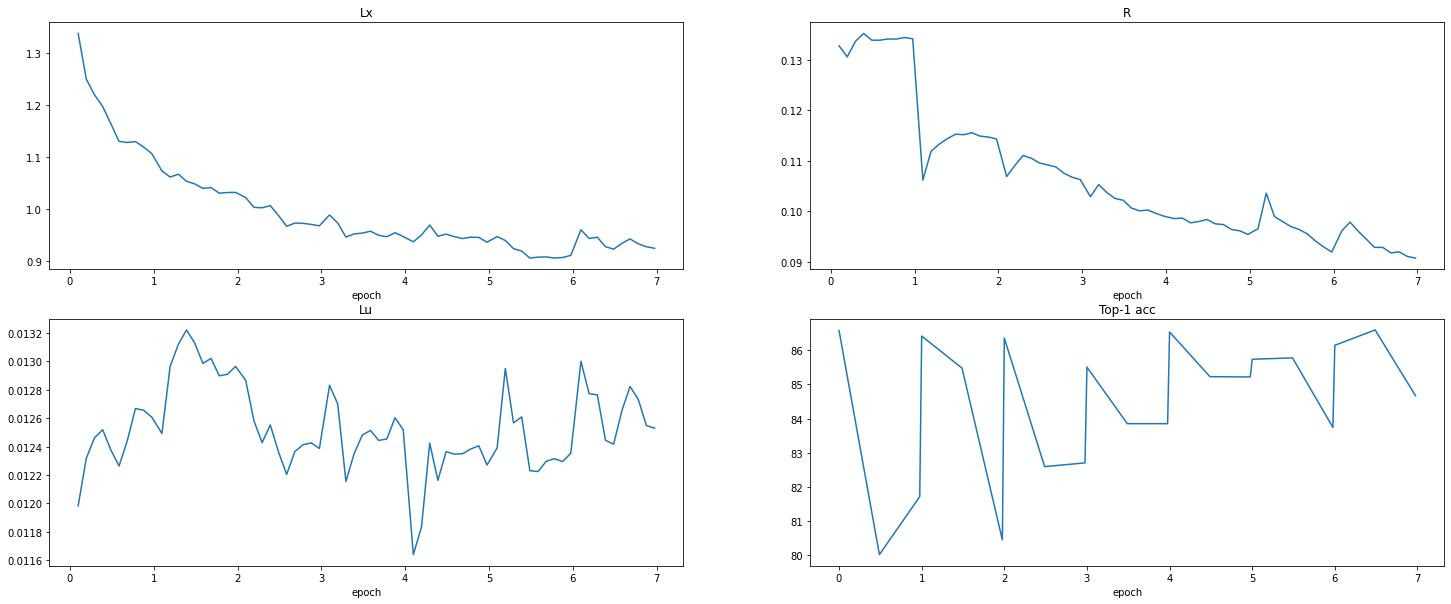

--------------------
Current lambda 5


<Figure size 432x288 with 0 Axes>

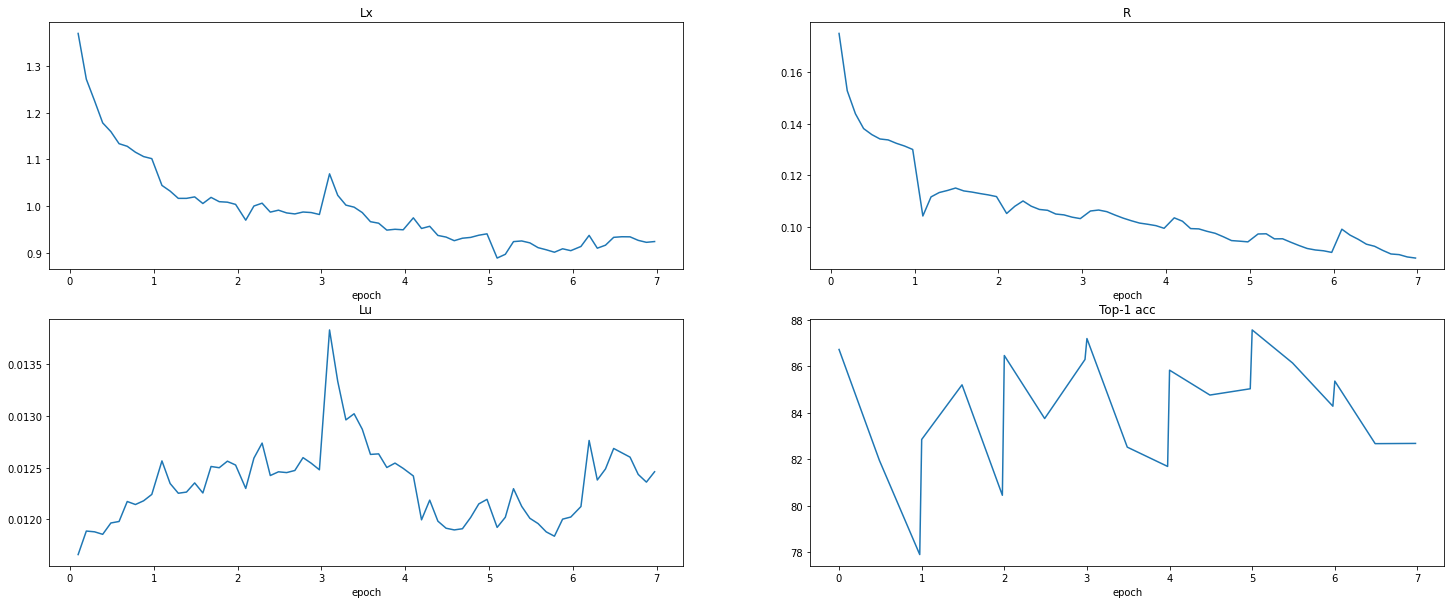

--------------------
Current lambda 10


<Figure size 432x288 with 0 Axes>

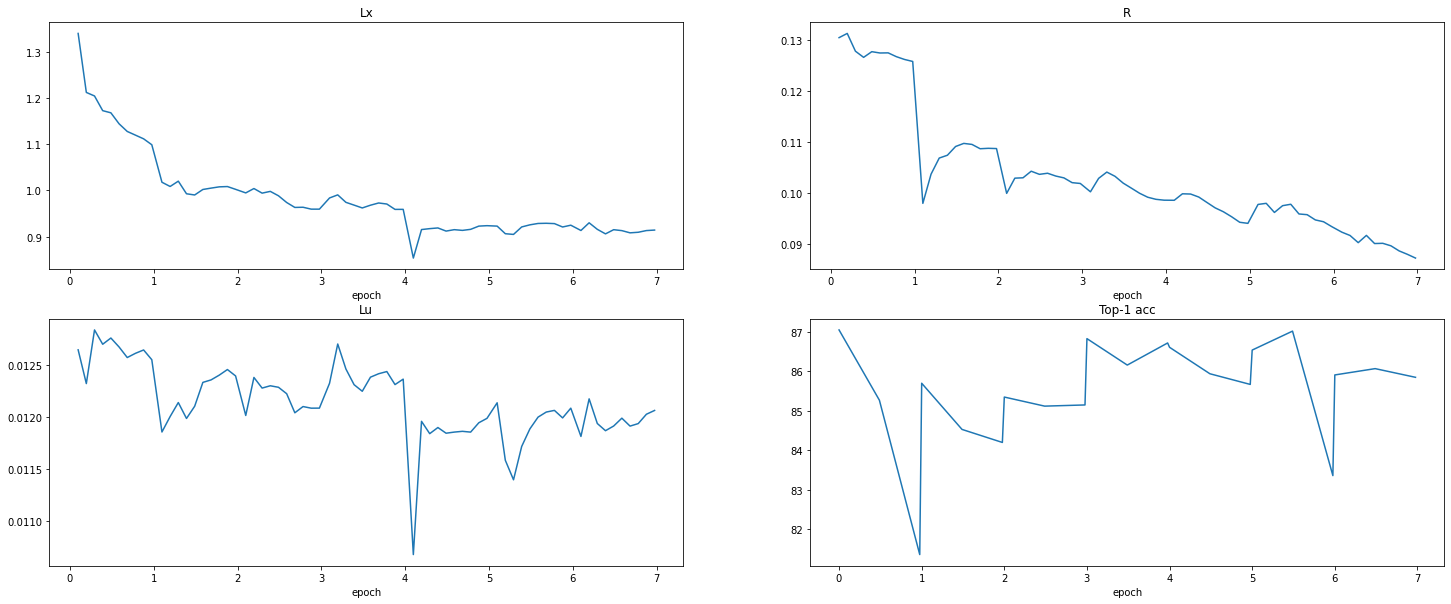

--------------------
Current lambda 15


<Figure size 432x288 with 0 Axes>

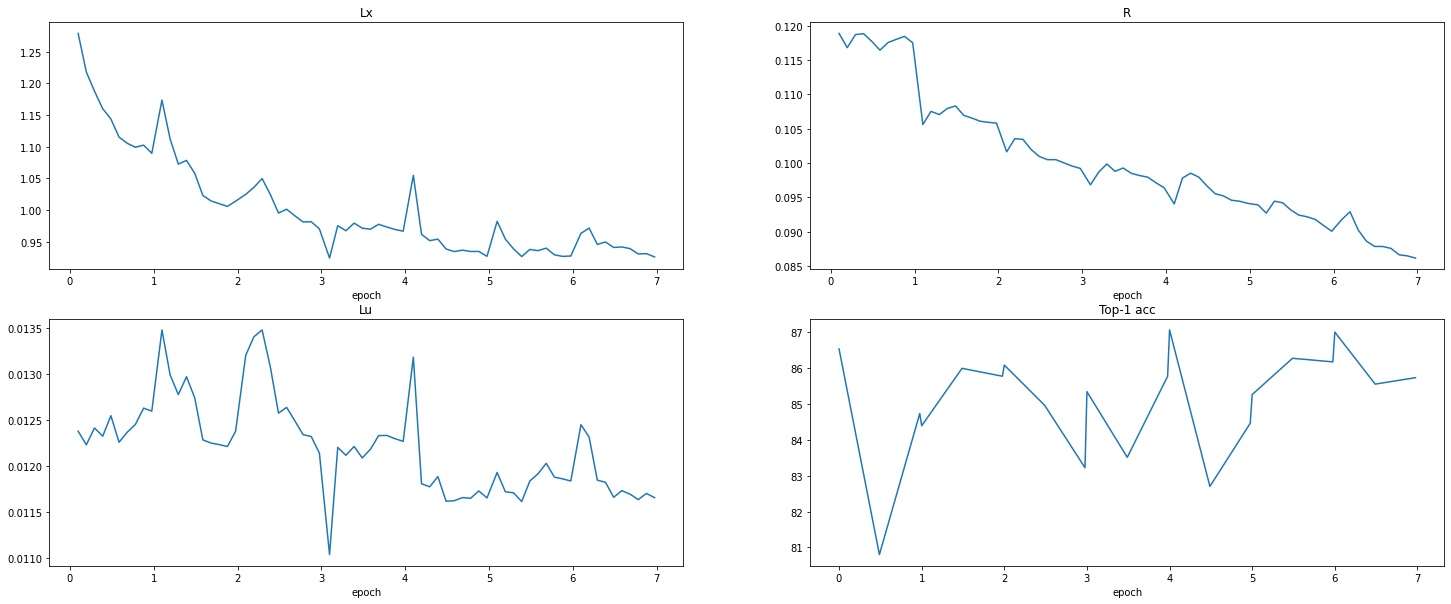

--------------------
Current lambda 20


<Figure size 432x288 with 0 Axes>

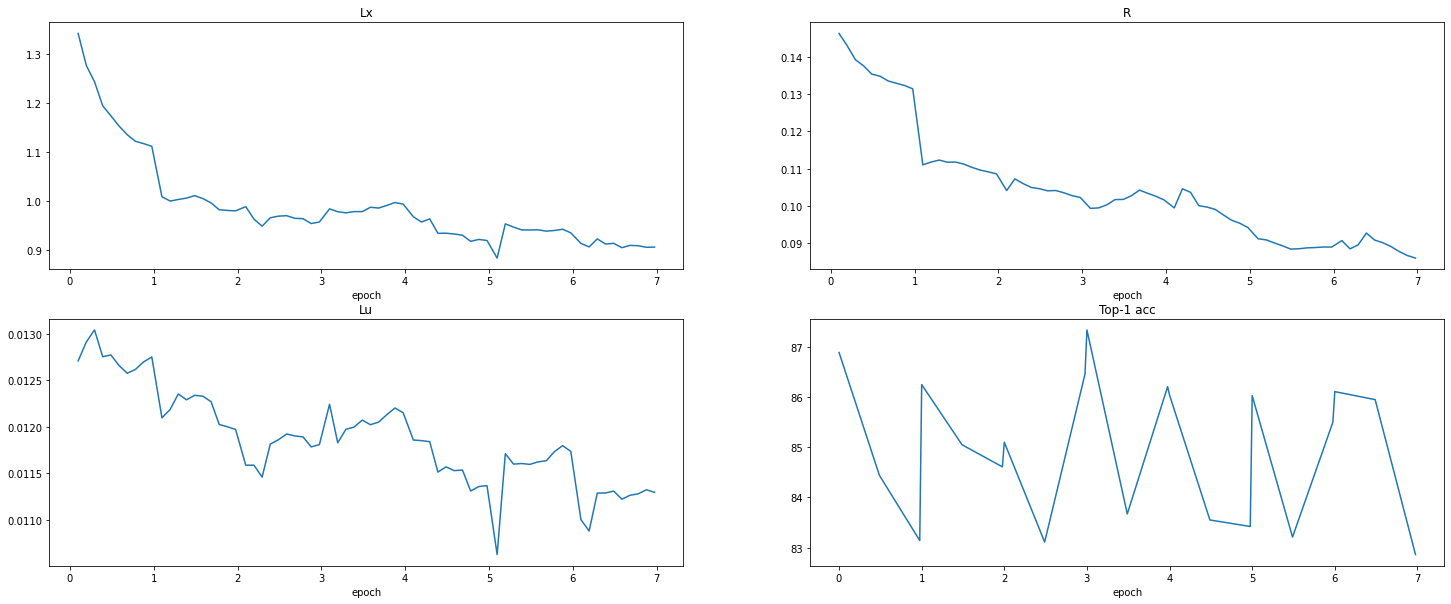

--------------------
Current lambda 30


<Figure size 432x288 with 0 Axes>

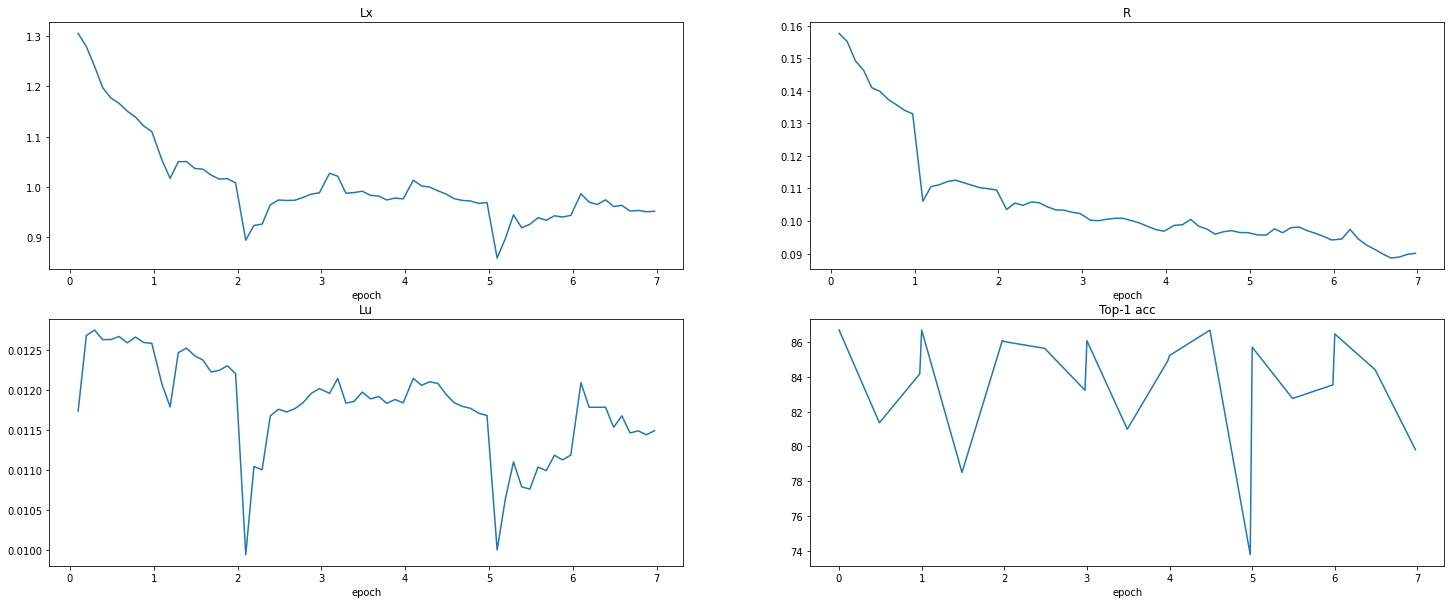

--------------------
Current lambda 150


<Figure size 432x288 with 0 Axes>

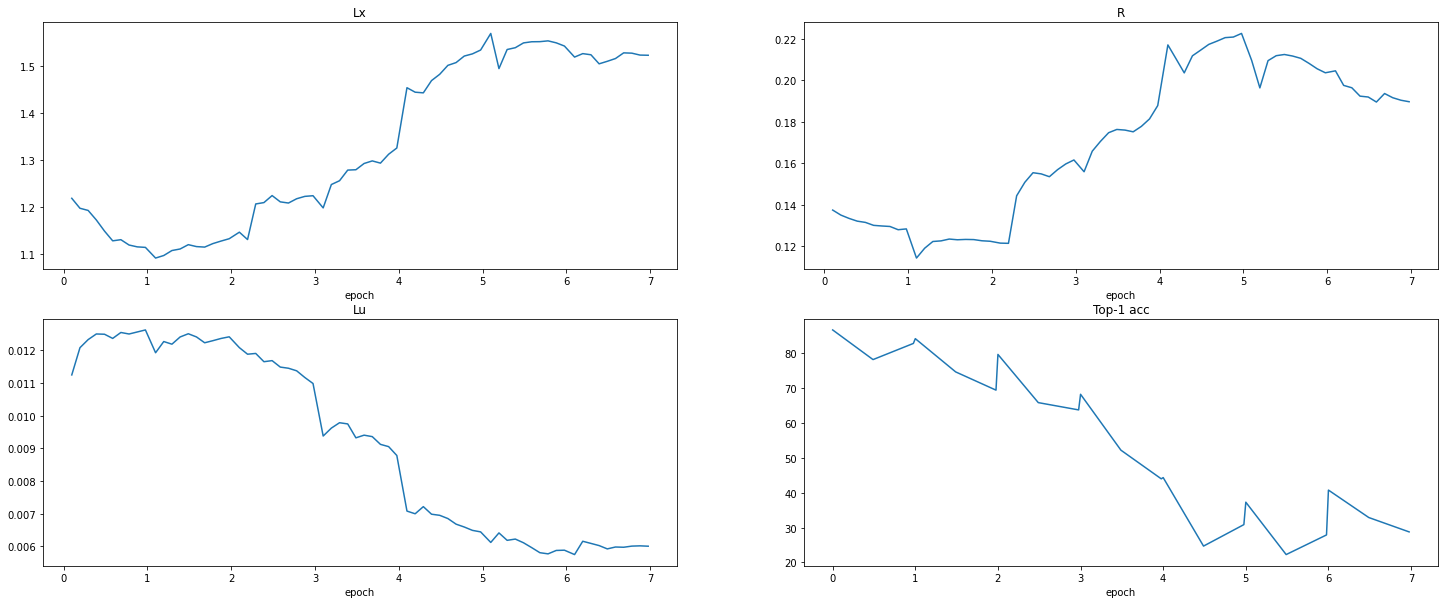

--------------------


In [46]:
for current_lambda_u in [2 , 5 , 10 , 15, 20, 30, 150]:
    print(f'Current lambda {current_lambda_u}')
    plt.clf()
    plot_result(torch.load(f'runs/reproduce_lu_{current_lambda_u}.bin'))
    plt.show()
    print('-'* 20)